In [1]:
'''
주제/키워드가 주어졌을때 다음을 시각화 한다
1. 구글 트렌드
2. 투자
3. 인수
'''

'\n\xec\xa3\xbc\xec\xa0\x9c/\xed\x82\xa4\xec\x9b\x8c\xeb\x93\x9c\xea\xb0\x80 \xec\xa3\xbc\xec\x96\xb4\xec\xa1\x8c\xec\x9d\x84\xeb\x95\x8c \xeb\x8b\xa4\xec\x9d\x8c\xec\x9d\x84 \xec\x8b\x9c\xea\xb0\x81\xed\x99\x94 \xed\x95\x9c\xeb\x8b\xa4\n1. \xea\xb5\xac\xea\xb8\x80 \xed\x8a\xb8\xeb\xa0\x8c\xeb\x93\x9c\n2. \xed\x88\xac\xec\x9e\x90\n3. \xec\x9d\xb8\xec\x88\x98\n'

In [1]:
import pandas as pd
import re
import gensim
import pickle
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# load data
data_folder = '../data/csv_export/'
util_folder = '../util/'
trend_folder = '../data/trends/'
df_organizations = pd.read_csv(data_folder + 'organizations.csv'.format(data_folder), dtype={'first_funding_on': str, 'last_funding_on':str})
df_description = pd.read_csv(data_folder + 'organization_descriptions.csv')
df_funding_rounds = pd.read_csv(data_folder + 'funding_rounds.csv')
df_funds = pd.read_csv(data_folder + 'funds.csv')
df_investments = pd.read_csv(data_folder + 'investments.csv')
df_acq = pd.read_csv(data_folder + 'acquisitions.csv')

In [3]:
'''
주제가 주어졌을때 다음을 시각화 한다.
1. 구글 트렌드
2. 투자
3. 인수

keyword: google trend keyword (사전에 keyword.csv 이름의 파일을 trends.google.com 에서 다운 받아야 함)
words: 회사 설명에서 다음과 같은 단어가 있으면 포함시킨다.
expand: 기본 단어외의 관련 단어를 추가할 것인가?
plot_all: 3가지가 모두 나온 하나의 그래프 외에, 개별 그래프 3가지를 따로 표시할 것인가?
start_date: 시작 시점
'''
color1 = 'black'
color2 = 'grey'
color3 = '#80bfff'
color4 = 'red'


def visualize(keyword, words, expand = False, plot_all = False, start_date = '2004-01', cumulative = False):
    fig = plt.figure()
    condition = 'first_funding_on'

    # 1. google web search trend data
    df_google_trend = pd.read_csv(trend_folder + keyword + '.csv', header = 1)  
    column1, column2 = df_google_trend.columns

    df_google_trend['google_count'] = df_google_trend[column2].groupby(df_google_trend[column1].str[:7]).transform('mean')
    df_google_trend['year-month'] = df_google_trend[column1].str[:7]
    df_google_trend = df_google_trend.loc[:,['year-month', 'google_count']]
    df_google_trend = df_google_trend.drop_duplicates()
    df_google_trend.columns = ['year-month', 'google_count']
    if plot_all:
        df_google_trend.plot(kind = 'line', x = df_google_trend['year-month'], figsize = (30, 8))

    # 2. google news trend data
    df_google_news_trend = pd.read_csv(trend_folder + keyword + '_news.csv', header = 1)  
    column1, column2 = df_google_news_trend.columns
    df_google_news_trend['google_news_count'] = df_google_news_trend[column2].groupby(df_google_news_trend[column1].str[:7]).transform('mean')

    df_google_news_trend['year-month'] = df_google_news_trend[column1].str[:7]
    df_google_news_trend = df_google_news_trend.loc[:,['year-month', 'google_news_count']]
    df_google_news_trend = df_google_news_trend.drop_duplicates()
    df_google_news_trend.columns = ['year-month', 'google_news_count']
    if plot_all:
        df_google_news_trend.plot(kind = 'line', x = df_google_news_trend['year-month'], figsize = (30, 8))

    # load required dataset
    if 'word2company' not in globals():
        print('loading word2company')
        global word2company
        word2company = pickle.load(open(util_folder + 'word2company.pickle'))
    if 'model' not in globals():
        print('loading word2vec model')
        global model
        model = gensim.models.word2vec.Word2Vec.load(util_folder + 'word2vec')

    # expand word set if necessary
    # train 된 word2vec 을 사용하여 관련도가 높은 단어들을 포함한다
    final_words = []
    if type(words) == str:
        words = [words]
    for word in words:
        if ' ' in word:
            word = word.replace(' ', '_')
        if expand:
            if word not in model: continue
            _words = model.most_similar(word)
            _words = [str(_word) for _word, sim in _words]
            final_words.extend(_words)
        final_words.append(word)
    final_words = list(set(final_words))

    # choose companies that have relevant words
    companies = []
    for word in final_words:
        _companies = word2company.get(word, [])
        companies.extend(_companies)
    companies = list(set(companies))

    if not cumulative: # just to print once
        print('Google Trend: {}\n Companies with keywords:{}'.format(keyword, final_words))

    # 회사를 시기 별로 정리한다
    # 3. funding
    df_companies = df_organizations[df_organizations['uuid'].isin(companies)]
    df = pd.DataFrame()
    df['date'] = df_companies["first_funding_on"]
    df = df[~df['date'].isnull()]
    df['year-month'] = df['date'].str[:7]
    funding = df.groupby(df['year-month']).size().reset_index()
    funding.columns = ['year-month', 'funding_count']
    funding = funding[funding['year-month'] >= start_date]
    if plot_all:
        funding.plot(kind = 'bar', x = funding['year-month'], figsize = (30, 8))


    df_merged = pd.merge(df_google_trend, funding, on = 'year-month', how = 'outer')
    df_merged = df_merged.merge(df_google_news_trend, on = 'year-month', how = 'outer')

    # 4. acquisition
    df = df_acq[df_acq['acquiree_uuid'].isin(companies)]
    if not cumulative:
#         print(df[['acquiree_name', 'acquirer_name', 'acquired_on']].sort_values('acquired_on'))
        to_print = df.sort_values('acquired_on')[['acquired_on', 'acquiree_name']]
        to_print['acquiree_name'] = to_print['acquiree_name'].apply(lambda x: x[:15])
        to_print = to_print.to_string(index = False)
        print(to_print)
#         print df.to_string(index=False)

    df = df.loc[:,['acquired_on']]
    df['year-month'] = df['acquired_on'].str[:7]
    acq = df.groupby(df['year-month']).size().reset_index()
    acq.columns = ['year-month', 'acq_count']
    acq = acq[acq['year-month'] >= start_date]

    if plot_all:
        acq.plot(kind = 'bar', x = acq['year-month'], figsize = (30, 8))

    df_merged = pd.merge(df_merged, acq, on = 'year-month', how = 'outer')
    df_merged = df_merged.sort_values(['year-month'])    
    df_merged['year'] = np.where(df_merged['year-month'].str[5:7] == '01', df_merged['year-month'].str[:4], '')

    if cumulative:
        df_merged['funding_count'] = df_merged['funding_count'].fillna(0)
        df_merged['funding_count'] = df_merged['funding_count'].cumsum()

        div_by = 100.0 / (df_merged['funding_count'].max() + 1)
        df_merged['google_count'] /= div_by
        df_merged['google_news_count'] /= div_by

        df_merged['acq_count'] = df_merged['acq_count'].fillna(0)
        df_merged['acq_count'] = df_merged['acq_count'].cumsum()
        df_merged['acq_count'] /= ((df_merged['acq_count'].max()) / (df_merged['funding_count'].max() + 1))

        df_merged[['year-month', 'google_count', 'google_news_count', 'funding_count', 'acq_count']].plot(x = df_merged['year'], linestyle = '-', color = [color1, color2, color3, color4], fontsize = 25, figsize = (30, 8)).legend(loc = 2, fontsize = 20, labels = ['google web search trend', 'google news trend', '# funding',  '# M&A',])


    else:        

        div_by = 100.0 / (df_merged['funding_count'].max() + 1)
        df_merged['google_count'] /= div_by
        df_merged['google_news_count'] /= div_by


        ax = df_merged[['year-month', 'google_count', 'google_news_count']].plot(x = df_merged['year'], linestyle = '-', color = [color1, color2])
        df_merged[['year-month', 'funding_count', 'acq_count']].plot(x = df_merged['year'], kind = 'bar', rot = 0, ax = ax, fontsize = 25, figsize = (30, 8), color = [color3, color4]).legend(loc = 2, fontsize = 20, labels = ['google web search trend', 'google news trend', '# funding', '# M&A'])

def visualize_all(keyword, words, expand = False, plot_all = False, start_date = '2004-01'):
    visualize(keyword, words, expand = expand, plot_all = plot_all, start_date = start_date, cumulative = False)
    visualize(keyword, words, expand = expand, plot_all = plot_all, start_date = start_date, cumulative = True)

Google Trend: augmented_reality
 Companies with keywords:['augmented_reality']
acquired_on    acquiree_name
2012-02-23             Vibe
2012-10-03          Viewdle
2013-04-10          iOnRoad
2015-01-01         Caugnate
2015-05-13      ARToolworks
2015-05-28           Metaio
2015-09-15         Looksery
2015-09-24   Singapore Dine
2015-10-13      Pikato, Inc
2015-11-03          Vuforia
2015-12-20      Drishya360s
2016-04-25  cherrypicks alp
2016-05-06  ADS Reality Ltd
2016-08-11        3DPhy.com
2016-08-30          TrumpIt
2016-12-12  mwf-technology 
2016-12-13  Greenlight Insi
2017-04-13      XPerception


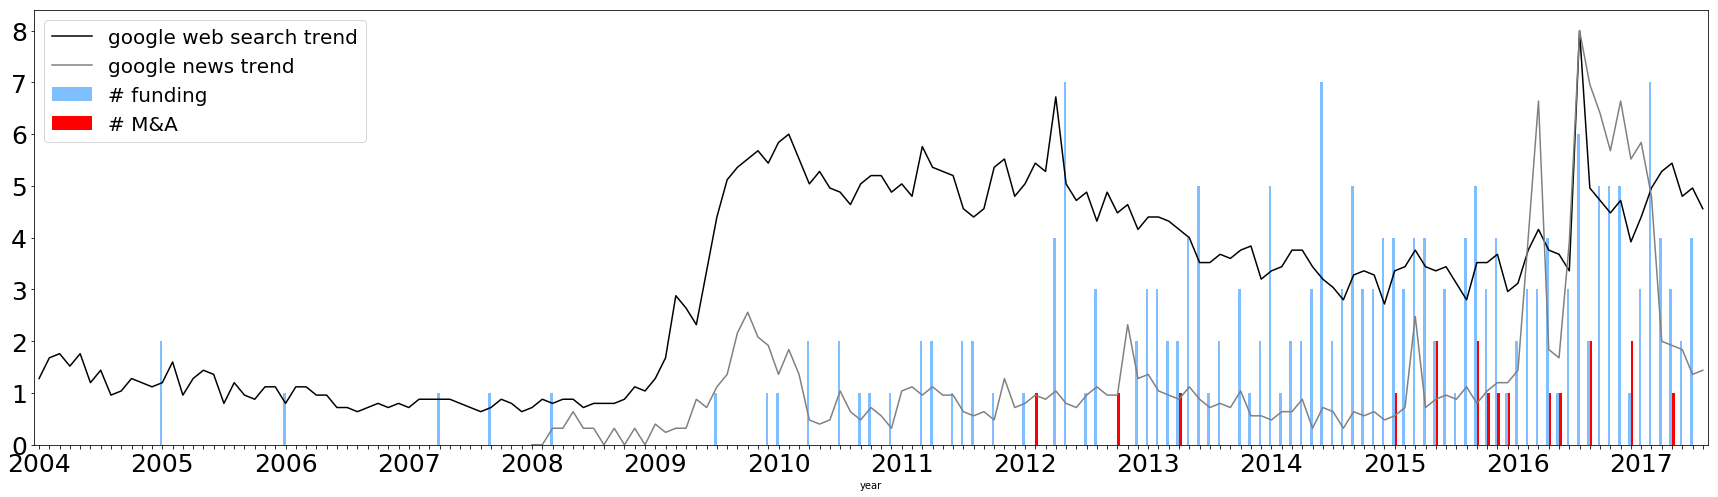

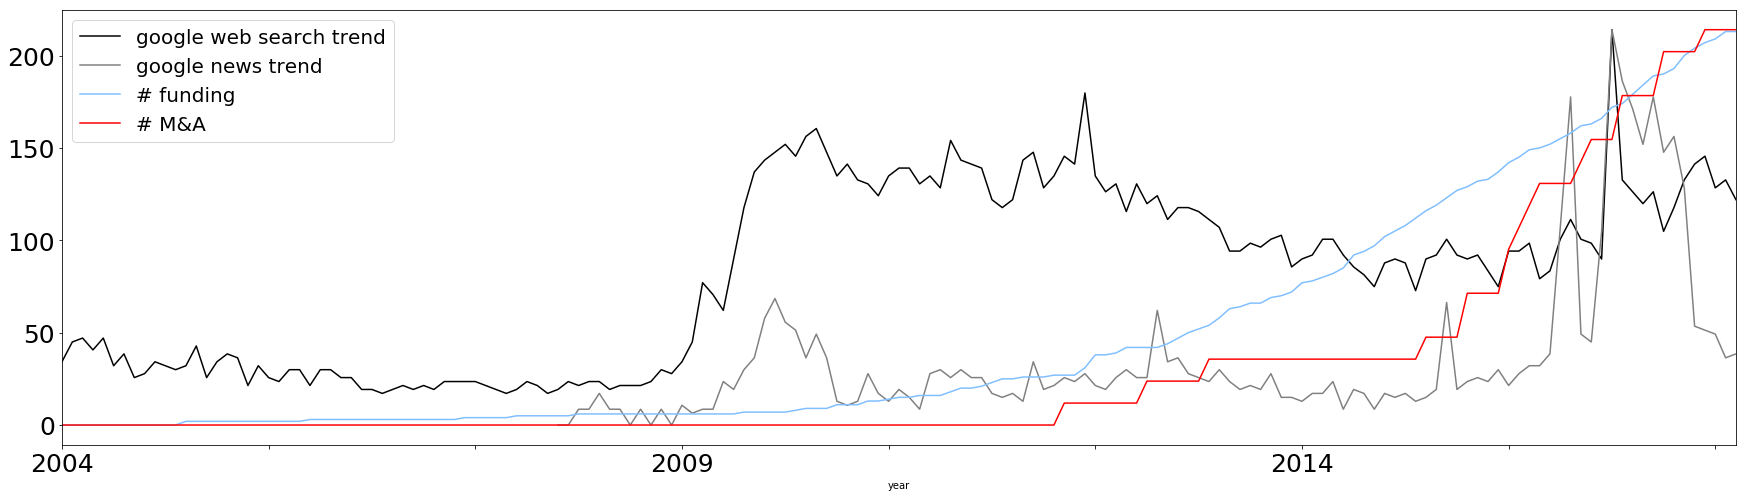

In [71]:
visualize_all('augmented_reality', ['augmented_reality'], expand = False, plot_all = False)

Google Trend: wearable
 Companies with keywords:['wearable_tech', 'wearables', 'smartwatch', 'smart_glasses', 'wearable_device', 'wrist_worn', 'wearable_sensor', 'wearable_devices', 'wearable', 'wearable_technology']
acquired_on    acquiree_name
1999-03-02      Club Monaco
2004-11-01       Dspfactory
2005-08-03          Itronix
2008-12-08       Textronics
2010-09-07  Anaconda Sports
2010-09-17  The ERGObaby Ca
2011-03-22       C2O Mobile
2011-07-01      AppMade Lab
2012-04-13     Camera Corps
2012-07-31    Tonalite B.V.
2013-04-11       Fibers.com
2013-04-30        BodyMedia
2013-06-27  Tibion Bionic T
2013-07-18       PrimeSense
2013-08-31        WIMM Labs
2013-11-08    Bottle Rocket
2014-02-19  Skyhook Wireles
2014-04-06  ZXY Sport Track
2014-12-05          Visijax
2014-12-05  ICE ID Solution
2014-12-17    Vergence Labs
2015-01-21  Composyt Light 
2015-03-11             Kili
2015-06-01  Clothing Plus O
2015-09-10         CogniVue
2015-09-29  PA Consulting G
2015-10-21          SanDis

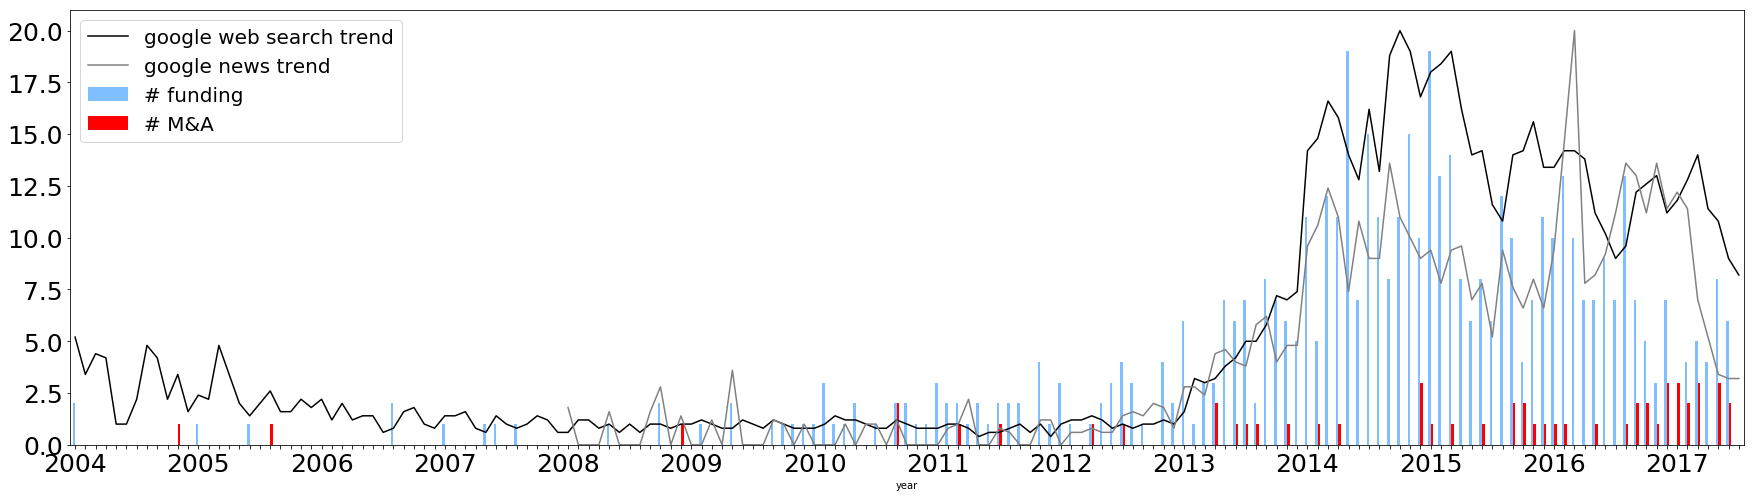

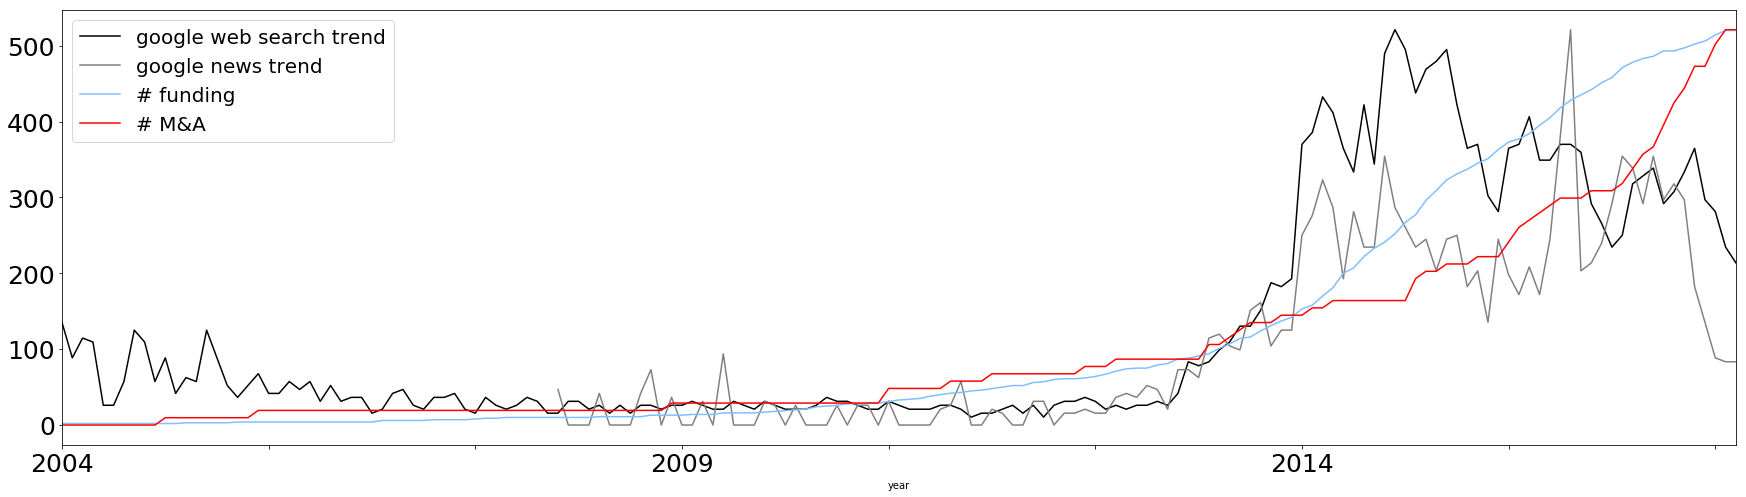

In [72]:
visualize_all('wearable', ['wearable', 'wearables', 'smartwatch', 'smart_glasses', 'wearable_device', 'wrist_worn', 'wearable_sensor', 'wearable_devices', 'wearable', 'wearable_tech', 'wearable_technology'], plot_all = False)

Google Trend: iot
 Companies with keywords:['iot']
acquired_on    acquiree_name
2003-03-31            Azlan
2006-08-21        Qualphone
2007-09-24       NetRegulus
2010-11-01            Stuzo
2012-08-03       SpringSoft
2014-02-19  Skyhook Wireles
2014-03-19  P-Device System
2014-06-10         Viryanet
2014-10-07           Radius
2014-12-01          Octoblu
2015-01-20  Red Bend Softwa
2015-01-22   Annapurna Labs
2015-02-10   Wireless Logic
2015-03-12         2lemetry
2015-03-18  Vitesse Semicon
2015-03-20  Coversant, Inc.
2015-03-30  Feeney Wireless
2015-04-30  LightMiner Syst
2015-06-04      TierConnect
2015-07-30   Sansa Security
2015-08-27       SeeControl
2015-09-24      AppCarousel
2015-10-26        ParStream
2016-01-12           Emmoco
2016-01-21  Unikernel Syste
2016-02-03   Jasper @ Cisco
2016-02-23        BlueKloud
2016-04-12       Skygistics
2016-04-18  GreenPeak Techn
2016-04-21  Device Authorit
2016-04-28  Broadcom's Wire
2016-06-16       Connode AB
2016-06-21  FalconX Acce

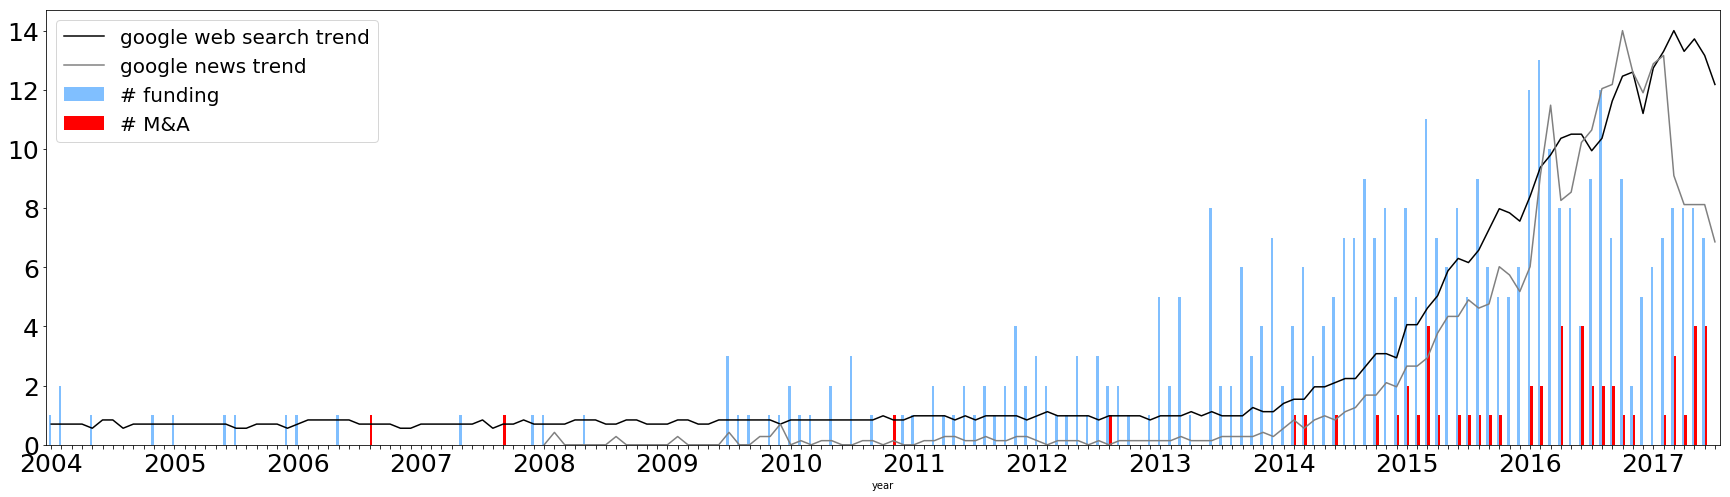

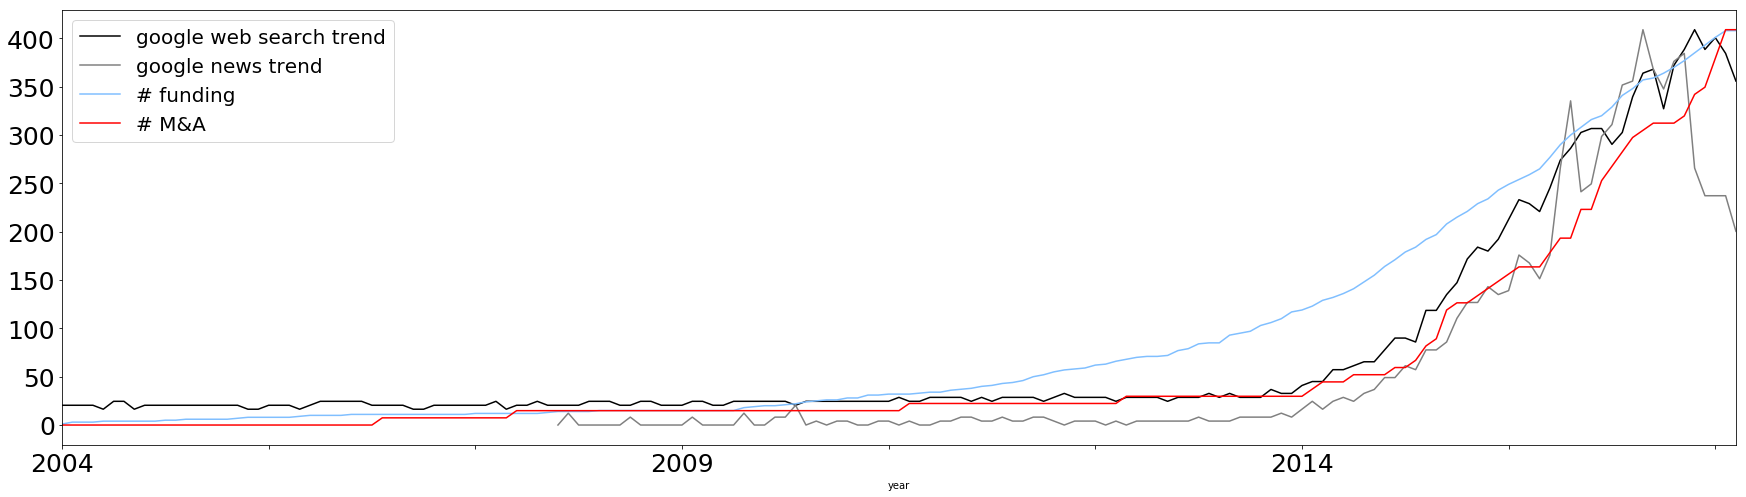

In [73]:
visualize_all('iot', 'iot', expand = False, plot_all = False)

Google Trend: bitcoin
 Companies with keywords:['digital_currencies', 'blockchain_technology', 'litecoin', 'bitcoins', 'crypto_currency', 'bitcoin', 'cryptocurrencies', 'cryptocurrency', 'crypto_currencies', 'digital_currency', 'bitcoin_litecoin']
acquired_on    acquiree_name
2013-09-26        Braintree
2013-12-24        ZeroBlock
2014-11-21  Justcoin Exchan
2014-12-01         yBitcoin
2014-12-16  Bongo Internati
2015-01-21  Bitcoin Magazin
2015-03-19   CoinTrader.net
2015-04-08         Cavirtex
2015-04-13       BuyBitcoin
2015-05-04   Bitcoin Brains
2015-06-25            Hyper
2015-06-25    Bits Of Proof
2015-07-02  Blockchain Tech
2015-08-01    Coin Republic
2015-08-12         Coinzone
2015-09-16  Unisend Latinam
2015-10-01        Coin Fire
2016-01-13         CoinDesk
2016-01-17       Coinsetter
2016-01-17         Cavirtex
2016-06-06         BitQuick
2016-06-14     XBT Provider
2016-07-20       BlockTrail
2016-07-27     GreenAddress
2016-08-01        Bitinvest
2016-12-13          Gli

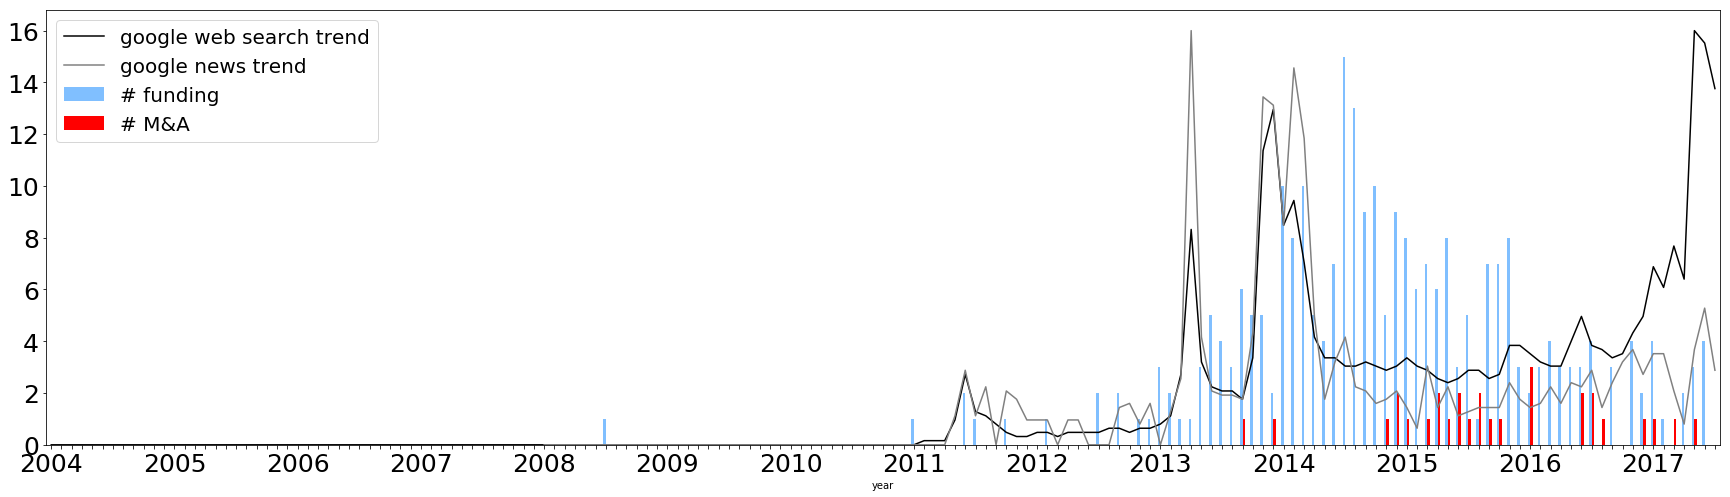

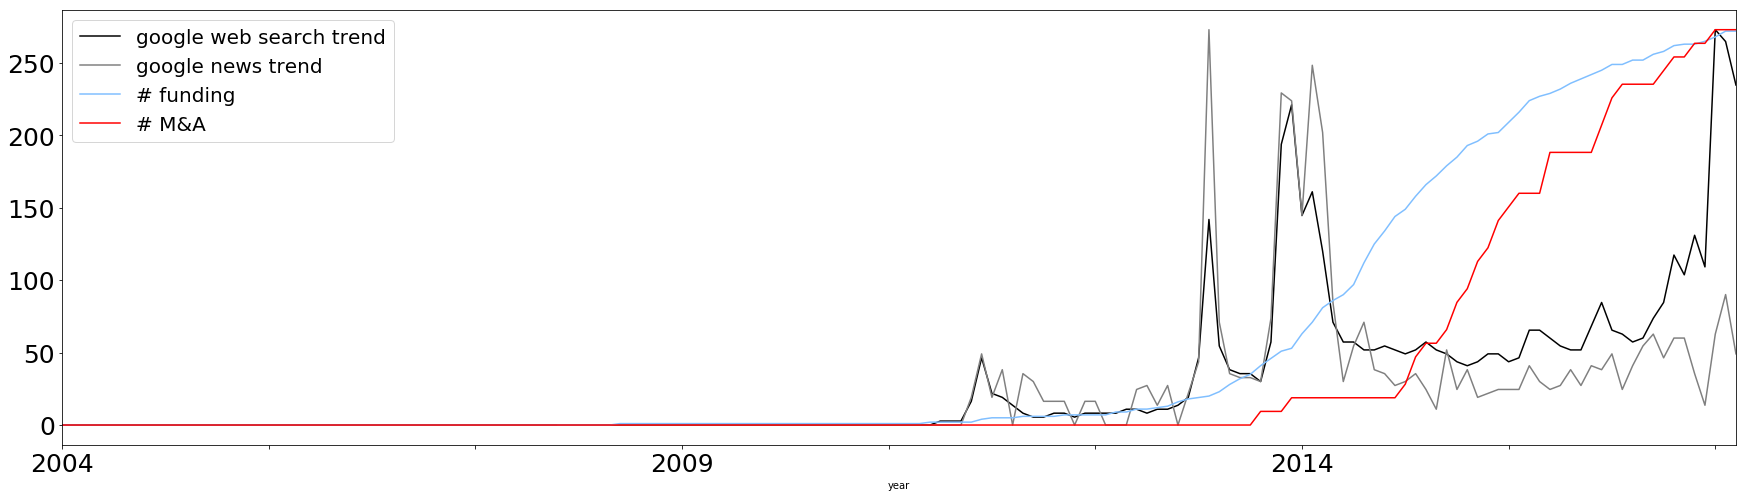

In [74]:
visualize_all('bitcoin', 'bitcoin', expand = True, plot_all = False)

Google Trend: blockchain
 Companies with keywords:['blockchain']
acquired_on    acquiree_name
2014-12-01         yBitcoin
2015-07-02  Blockchain Tech
2015-10-29    Blockstack.io
2016-06-08  Canaan Creative
2017-01-26        KreateIoT
2017-01-30        Lawnmower
2017-02-27             Skry
2017-04-04          Remitsy
2017-04-12           nChain
2017-05-20  Proof of Existe


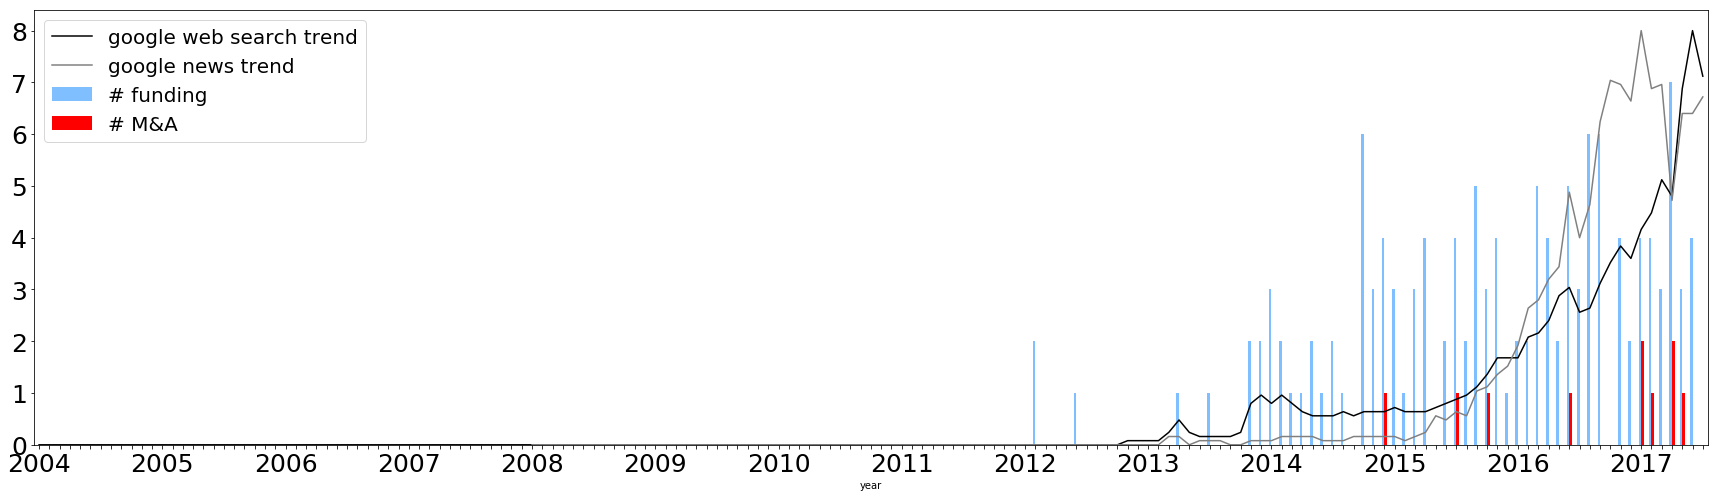

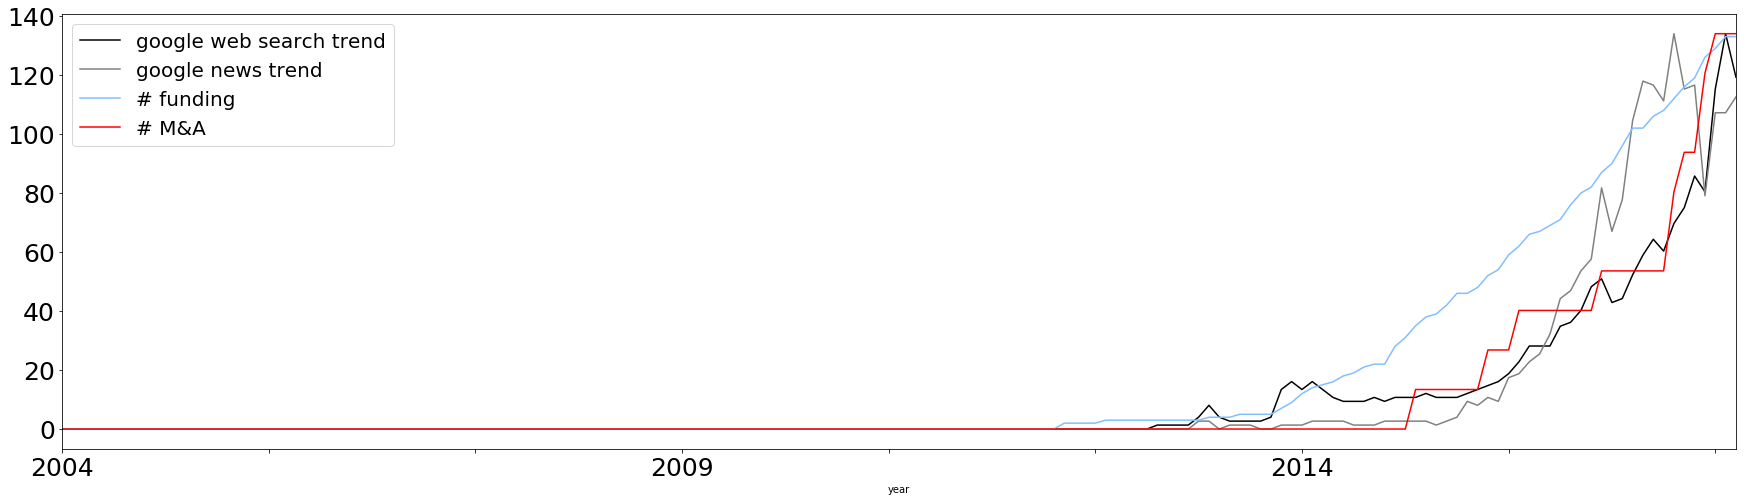

In [7]:
visualize_all('blockchain', 'blockchain', expand = False, plot_all = False)

Google Trend: deep_learning
 Companies with keywords:['deep_learning']
acquired_on    acquiree_name
2008-08-06       Parascript
2014-10-23   Dark Blue Labs
2014-10-23   Vision Factory
2015-03-04       AlchemyAPI
2015-10-05        Perceptio
2015-12-01           Orbeus
2016-08-09          Nervana
2016-08-16            SAIPS
2016-09-29  Wireless System
2017-01-13          Maluuba
2017-03-29       Siftr Labs
2017-04-05     ViDi Systems
2017-05-17           niland


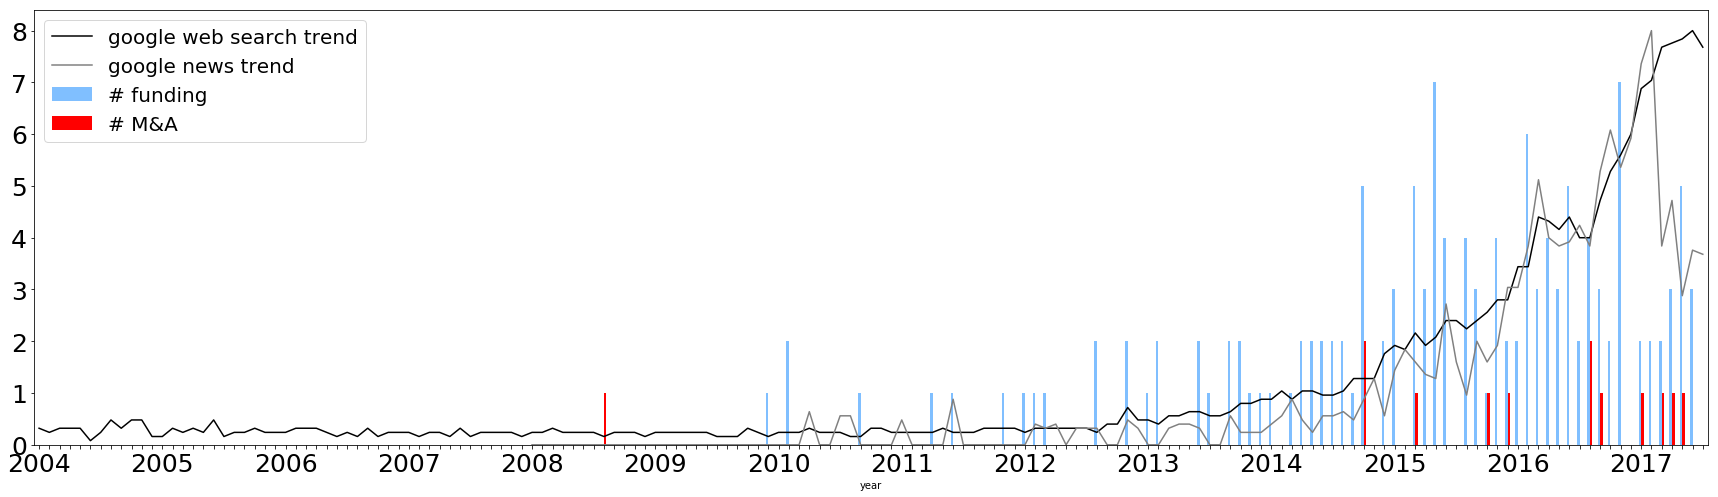

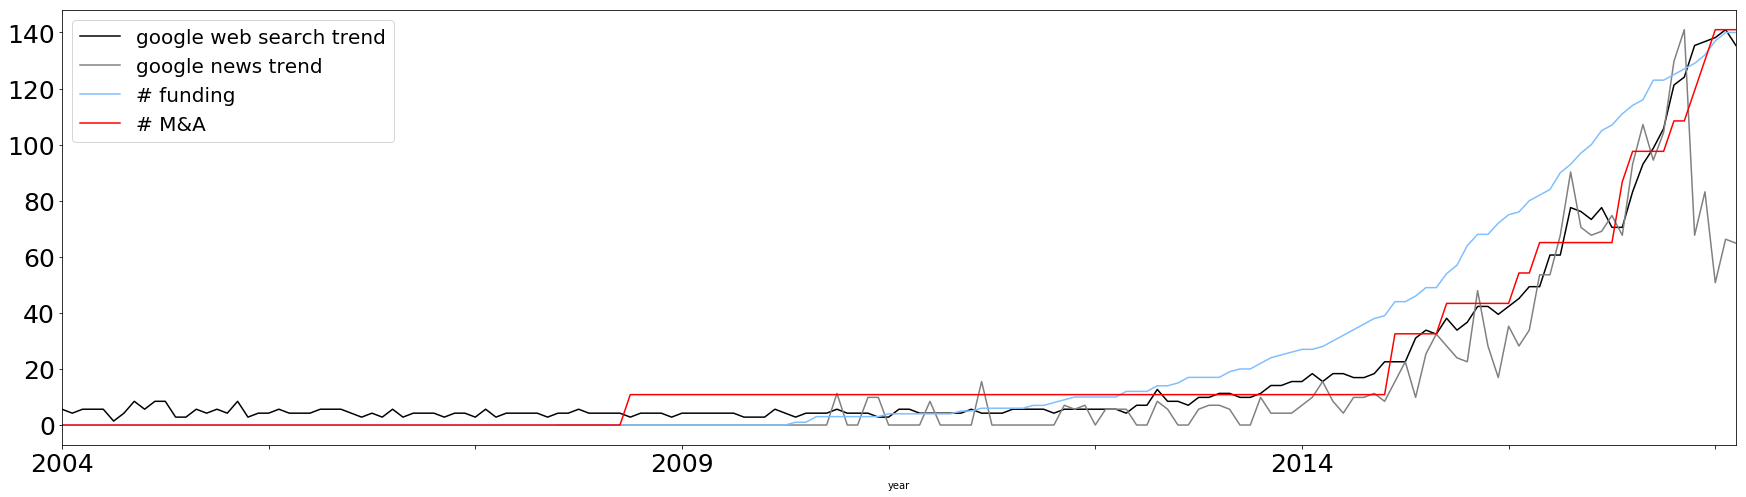

In [76]:
visualize_all('deep_learning', 'deep learning', expand = False, plot_all = False)

Google Trend: drone
 Companies with keywords:['remotely_operated', 'drone', 'uas', 'unmanned_aerial', 'uav', 'unmanned', 'uavs', 'drones', 'unmanned_aircraft', 'vtol', 'fixed_wing']
acquired_on    acquiree_name
2000-02-02    2B Technology
2006-01-06     Miltec Corp.
2006-06-21  Enerdyne Techno
2008-03-03  Athena Technolo
2008-06-03  Intelligent Aut
2008-07-16  Soil Machine Dy
2009-03-12  Advanced Cerami
2009-05-01  Cloud Cap Techn
2009-11-20  Submersible Tec
2010-01-22  Crossbow Techno
2010-01-25  Science, Engine
2010-08-09  Airborne Techno
2010-09-27  McKechnie Aeros
2011-01-13              LNX
2011-06-03  Crossbow Techno
2012-04-06         Gatewing
2012-05-31  Teledyne BlueVi
2012-11-13  Chandler/May, I
2012-12-17         ShotOver
2013-05-16  Arkwin Industri
2014-03-28     Ascenta (UK)
2014-04-14  Titan Aerospace
2014-09-03  Bolt Technology
2015-01-30  Engineering Sol
2015-02-09  Soil Machine Dy
2015-06-10  Broadcast Micro
2015-07-01            TREXA
2015-07-20  Adaptive Flight
2015-

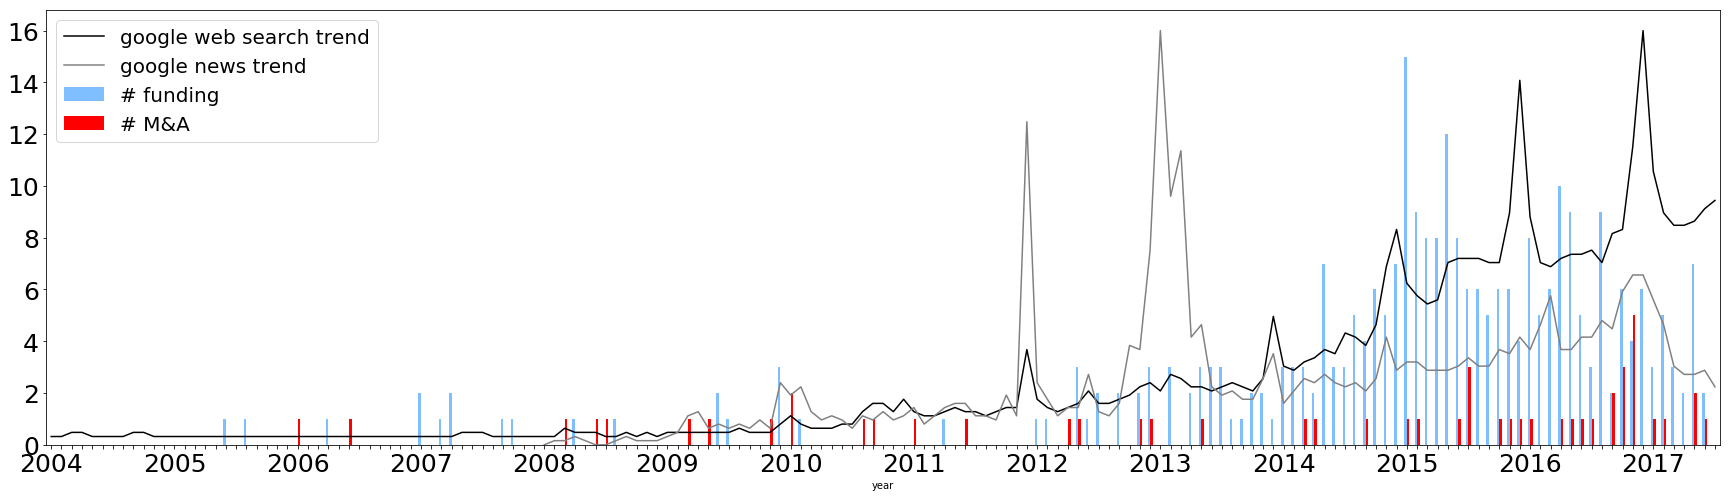

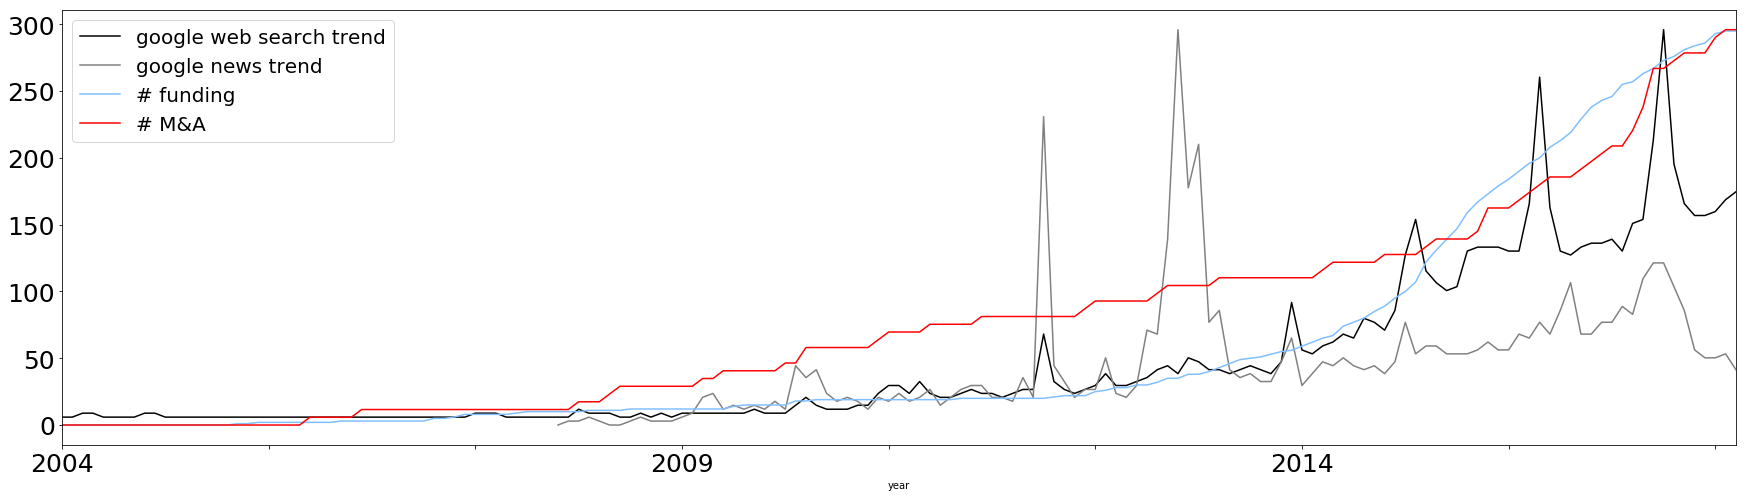

In [77]:
visualize_all('drone', 'drone', expand = True, plot_all = False)

Google Trend: social_media
 Companies with keywords:['social_media']
acquired_on    acquiree_name
1998-06-28   Submit Express
1999-03-01   Argon Networks
1999-12-01             Cone
2001-01-17        Webtrends
2005-03-08  J.D. Power and 
2005-03-29        Webtrends
2005-07-23         Blockdot
2006-03-24      Mobile-Mind
2006-05-22         Salesnet
2006-08-31       Hipcricket
2006-09-01       Via Caroli
2006-12-13  Quilter Cheviot
2006-12-20       DigitasLBi
2007-01-10  New Media Strat
2007-04-05        Advaliant
2007-04-11    Reprise Media
2007-07-18  Mediabistro.com
2007-10-01          Traffix
2007-12-11       stylediary
2008-01-31             Sway
2008-02-01           Snocap
2008-03-04            Pluck
2008-04-01           Umbria
2008-05-05    Absolute Punk
2008-06-25        UGENmedia
2008-07-15         OnlyWire
2008-07-16  Chirp Interacti
2008-08-26      Blogcritics
2008-09-29  Clear Blue Inte
2008-11-14    Ripple6, Inc.
2009-02-12        Mr. Youth
2009-03-05           SezWho
2009-0

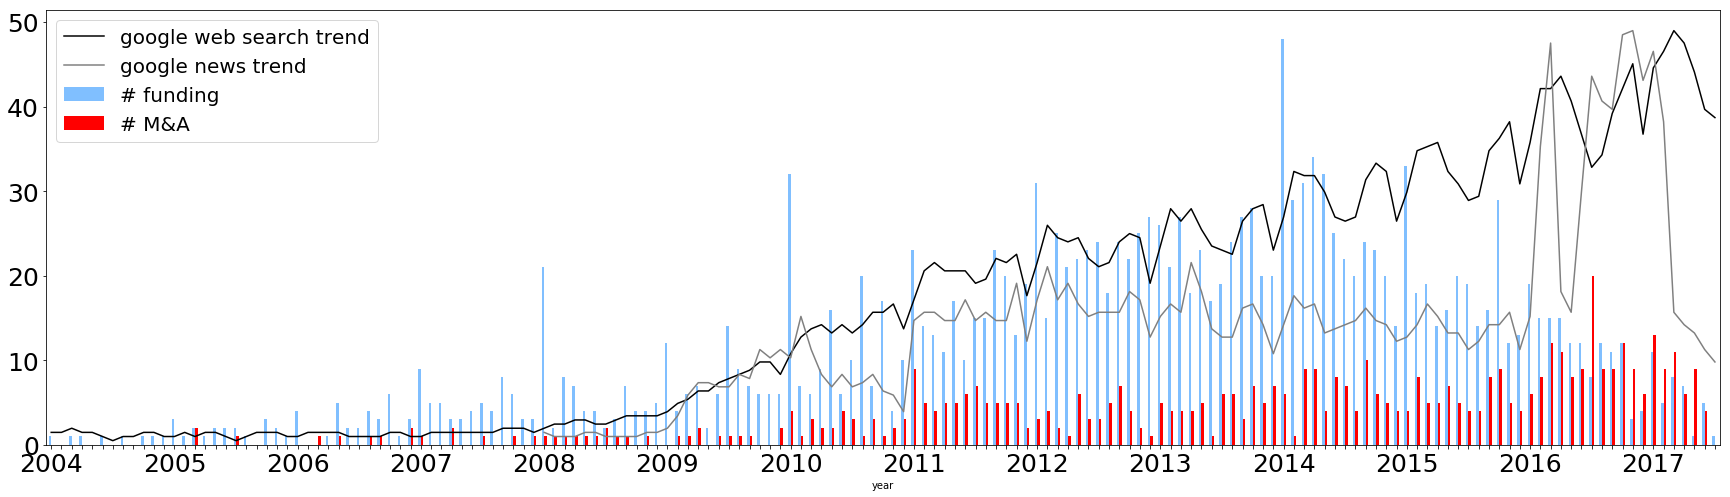

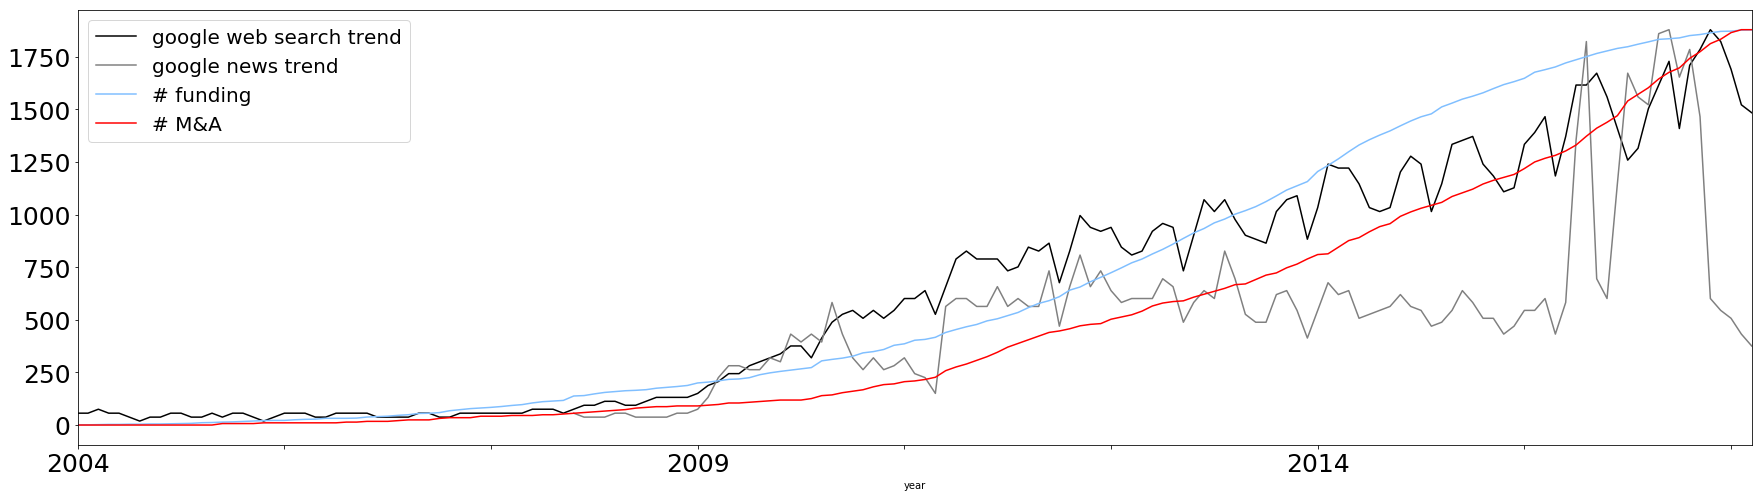

In [78]:
visualize_all('social_media', 'social_media', expand = False, plot_all = False)

Google Trend: self_driving_car
 Companies with keywords:['autonomous_driving', 'autonomous_vehicle', 'self_driving', 'driverless']
acquired_on    acquiree_name
2015-07-23       Ottomatika
2016-03-11  Cruise Automati
2016-03-29       StackStorm
2016-05-24  ADASENS Automot
2016-08-18             Otto
2016-12-01       MicroFuzzy


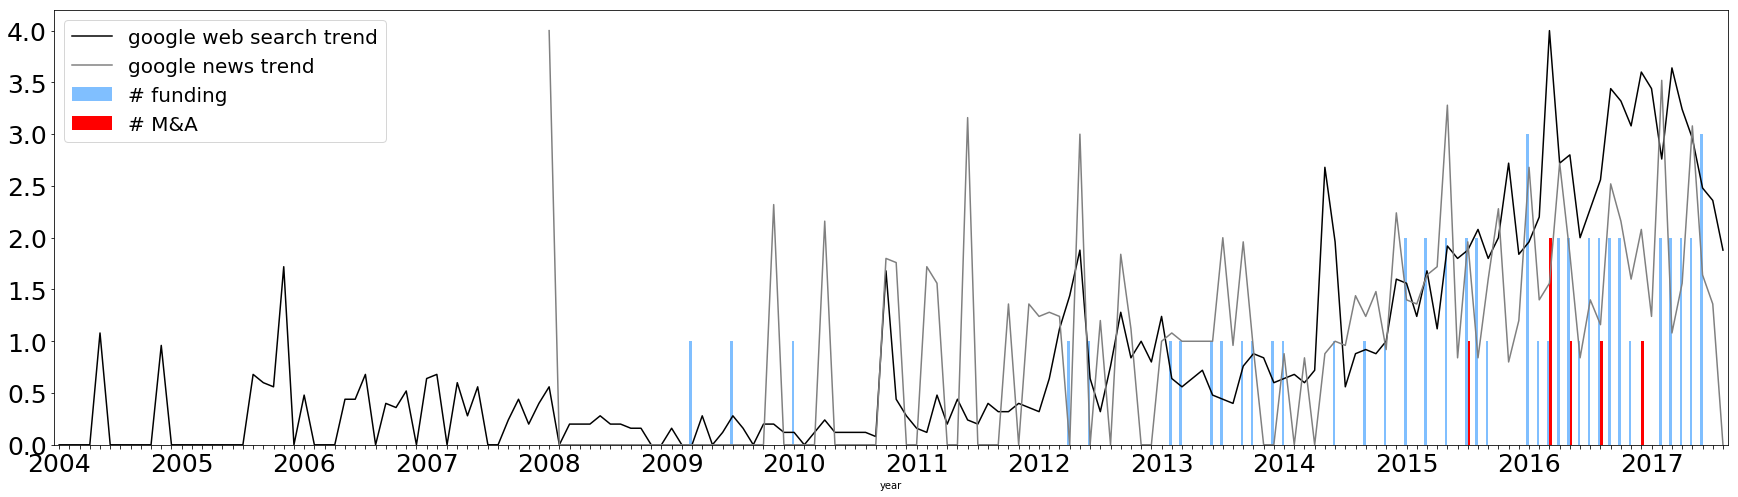

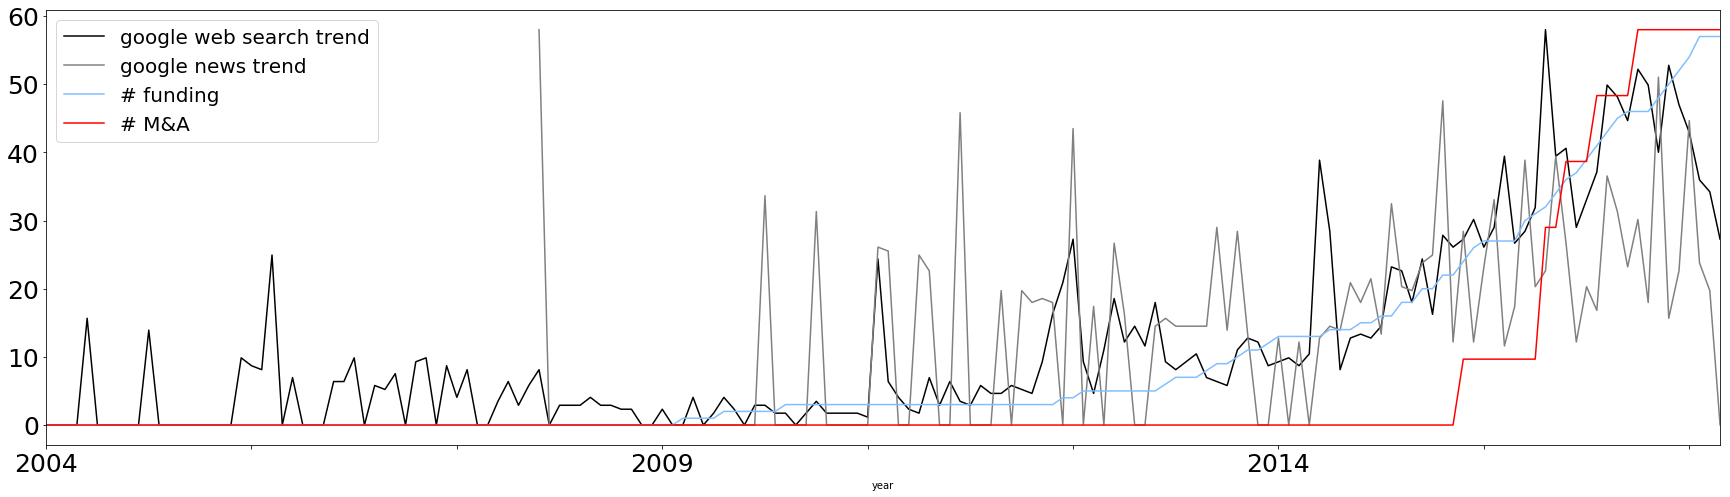

In [79]:
visualize_all('self_driving_car', ['self driving', 'autonomous driving', 'driverless', 'autonomous vehicle'], expand = False, plot_all = False)

Google Trend: neuroscience
 Companies with keywords:['neuroscience']
acquired_on    acquiree_name
2004-07-26  King Pharmaceut
2006-04-07  Rinat Neuroscie
2007-04-03          Hypnion
2008-02-12       Abfrontier
2008-05-09  BIOMOL Internat
2008-05-14  Leica Biosystem
2008-11-12  JNetDirect Bios
2010-10-12  King Pharmaceut
2011-03-04   TransMolecular
2011-05-27       NeuroFocus
2012-02-17  NeuroNexus Tech
2014-01-21          NuPathe
2014-03-03    Intific, Inc.
2015-01-11  Convergence Pha
2015-04-14         ProNerve
2015-05-18  Innerscope Rese
2016-08-09          Nervana
2016-11-29   MTI-GlobalStem
2017-03-02       Neurovance
2017-05-01  Kangaroo Kids E
2017-05-31  Constant Therap


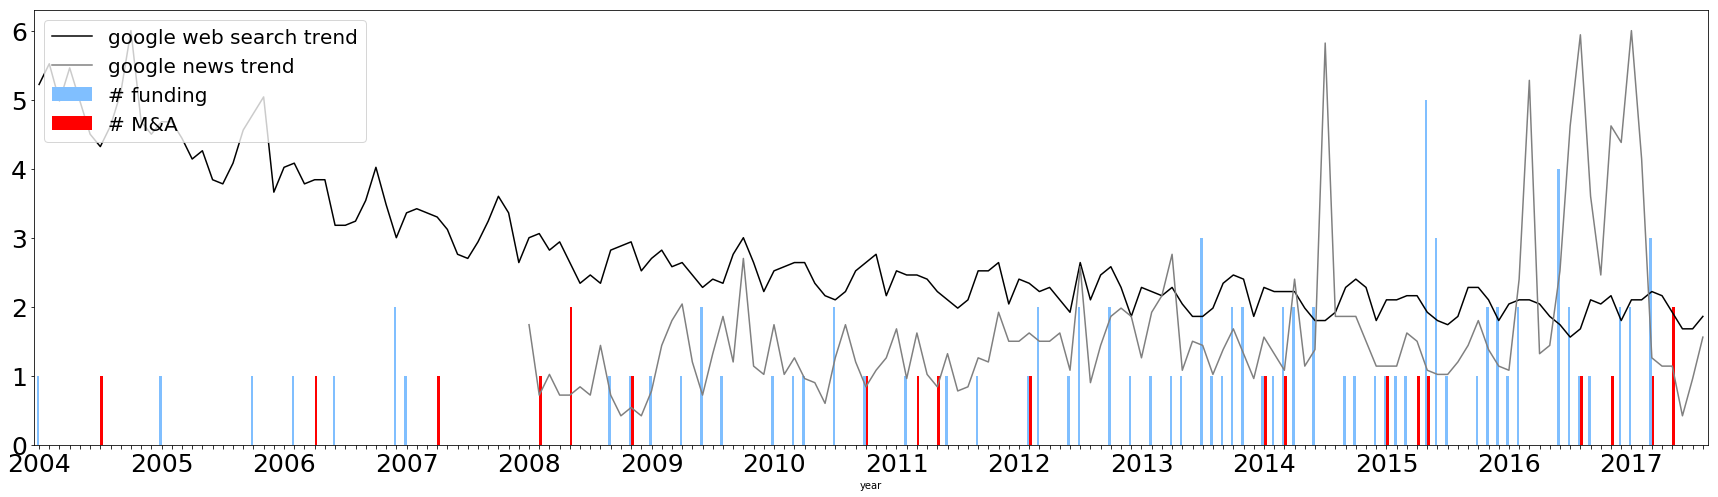

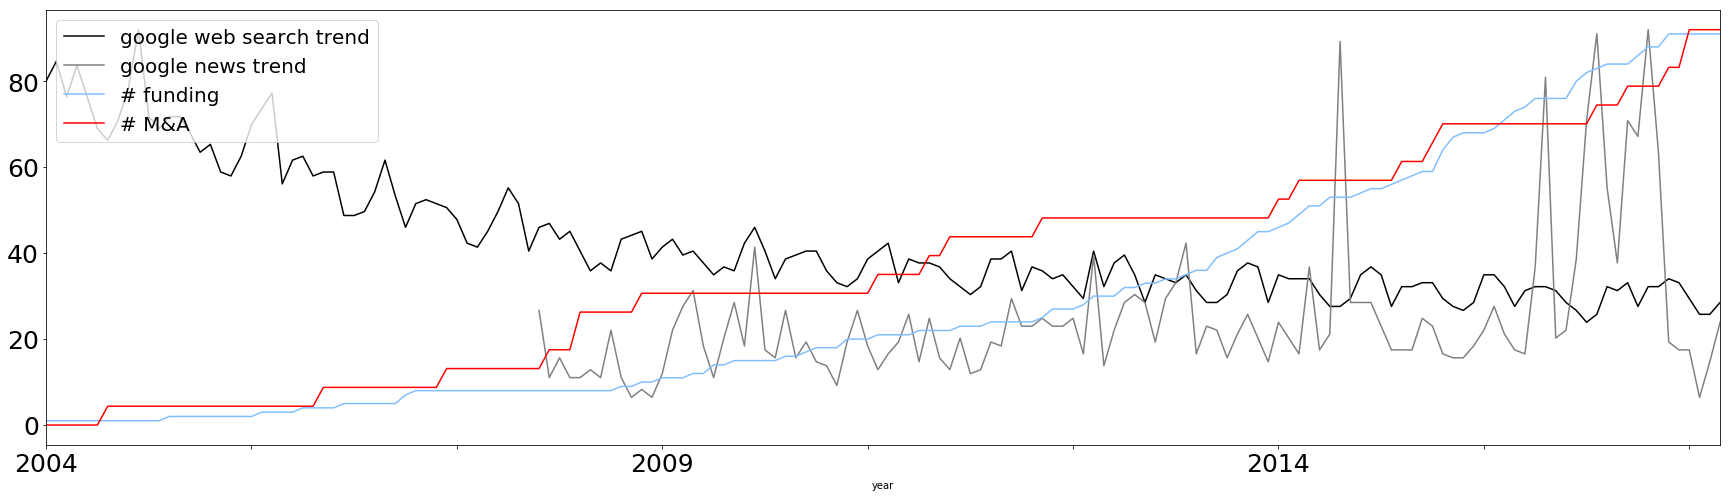

In [80]:
visualize_all('neuroscience', ['neuroscience'], expand = False, plot_all = False)

Google Trend: mobile_health_care
 Companies with keywords:[]
Empty DataFrame
Columns: [acquired_on, acquiree_name]
Index: []


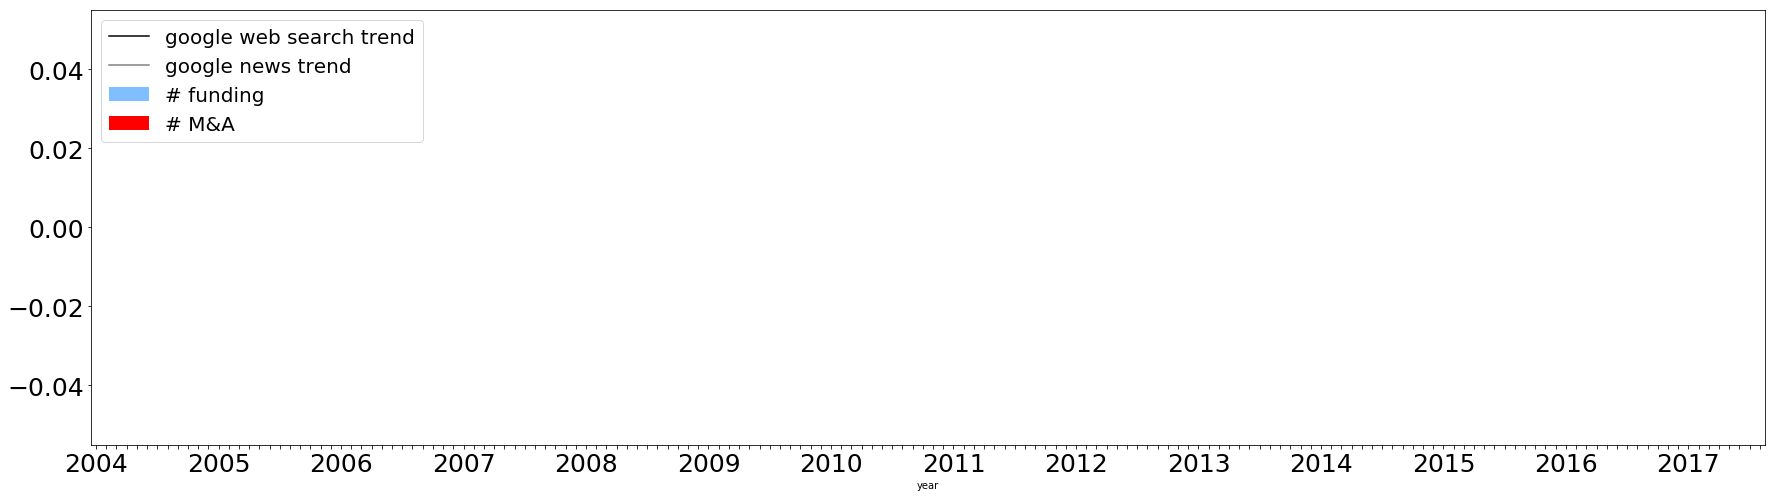

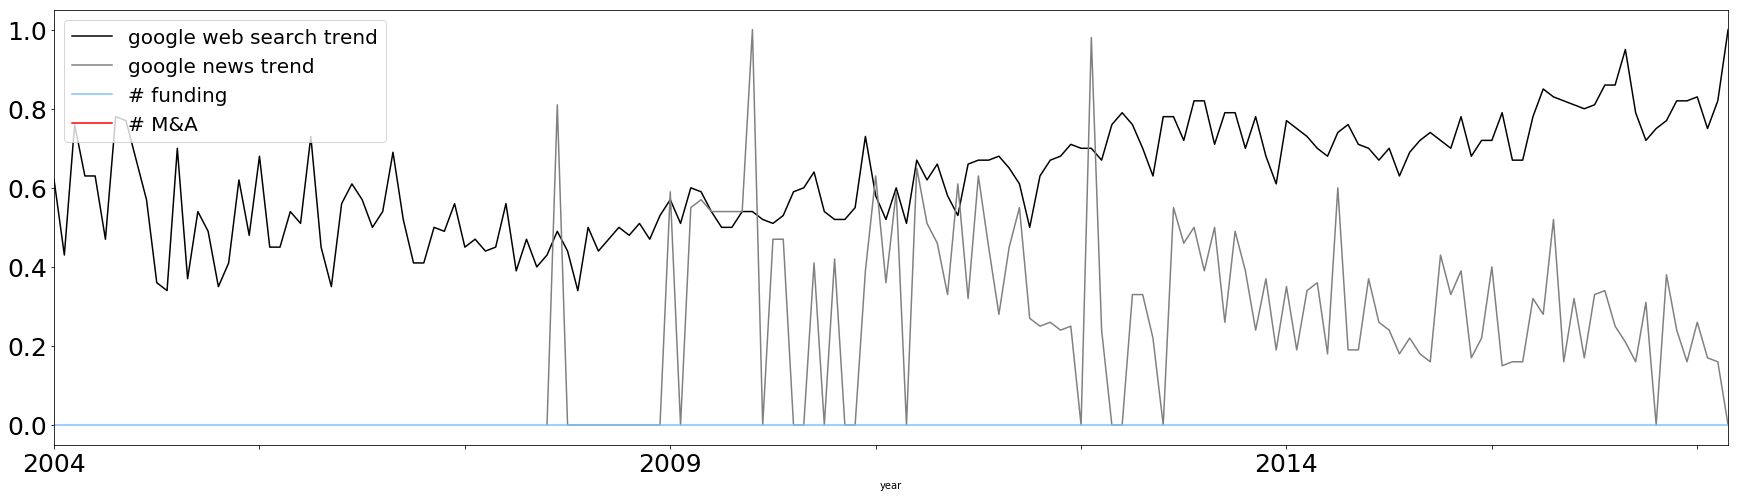

In [81]:
visualize_all('mobile_health_care', ['mobile health', 'mobile healthcare'], expand = True, plot_all = False)

Google Trend: social_robot
 Companies with keywords:[]
Empty DataFrame
Columns: [acquired_on, acquiree_name]
Index: []


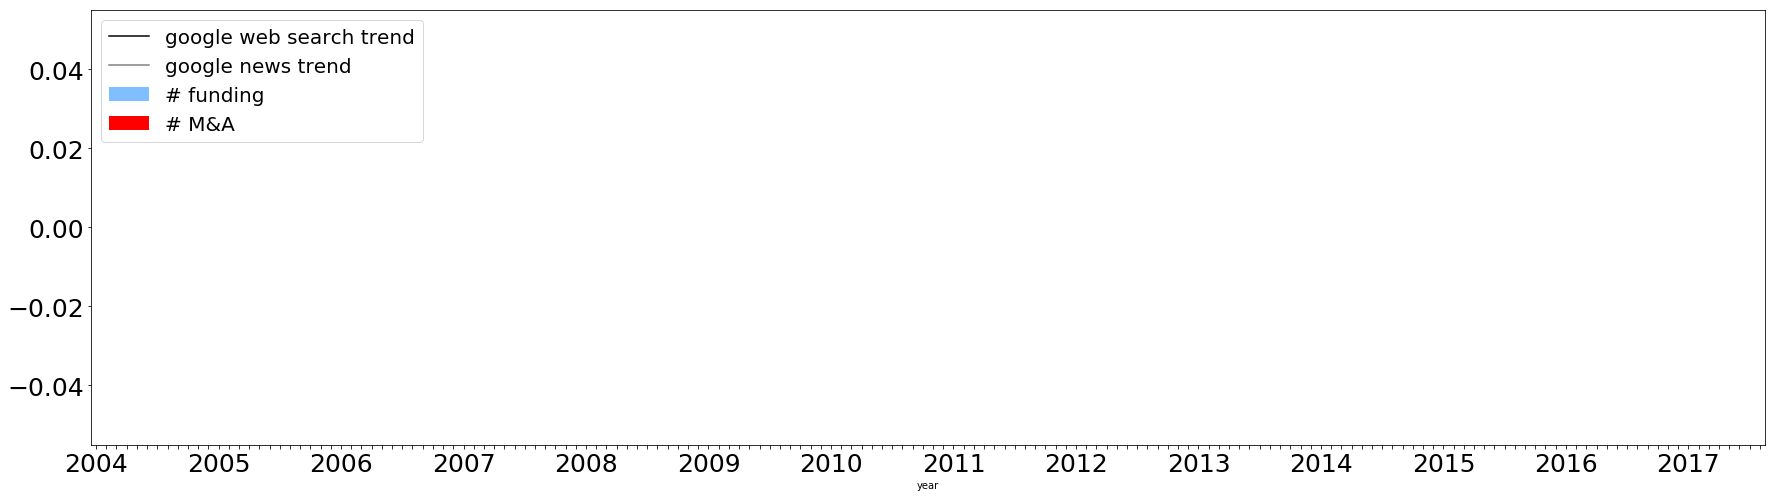

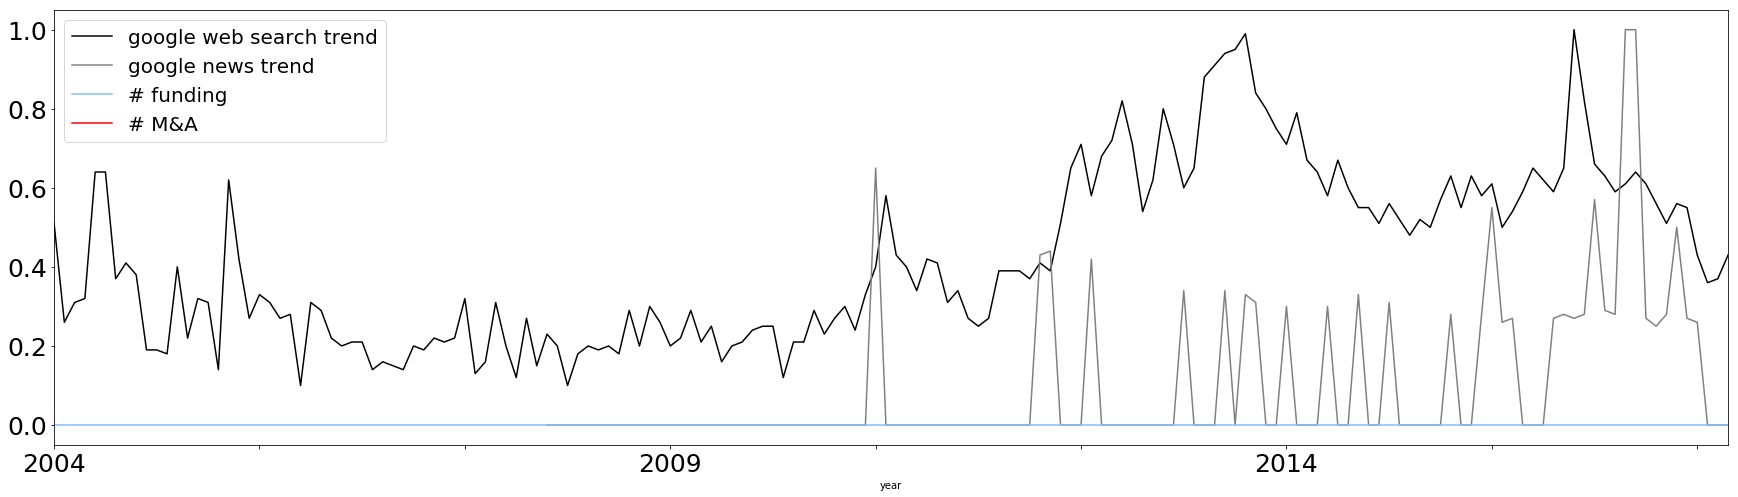

In [82]:
visualize_all('social_robot', 'social robot', expand = True, plot_all = False)

Google Trend: lidar
 Companies with keywords:['lidar']
acquired_on    acquiree_name
2003-06-23       Lizardtech
2007-02-14       Inpho GmbH
2011-07-29  Destiny Resourc
2012-12-03  GTA Geoinformat
2013-02-01  Allpoint System
2014-08-01            V-Gen
2016-01-25  Signal Processi
2016-02-19      Sigma Space
2016-03-16  Advanced Scient


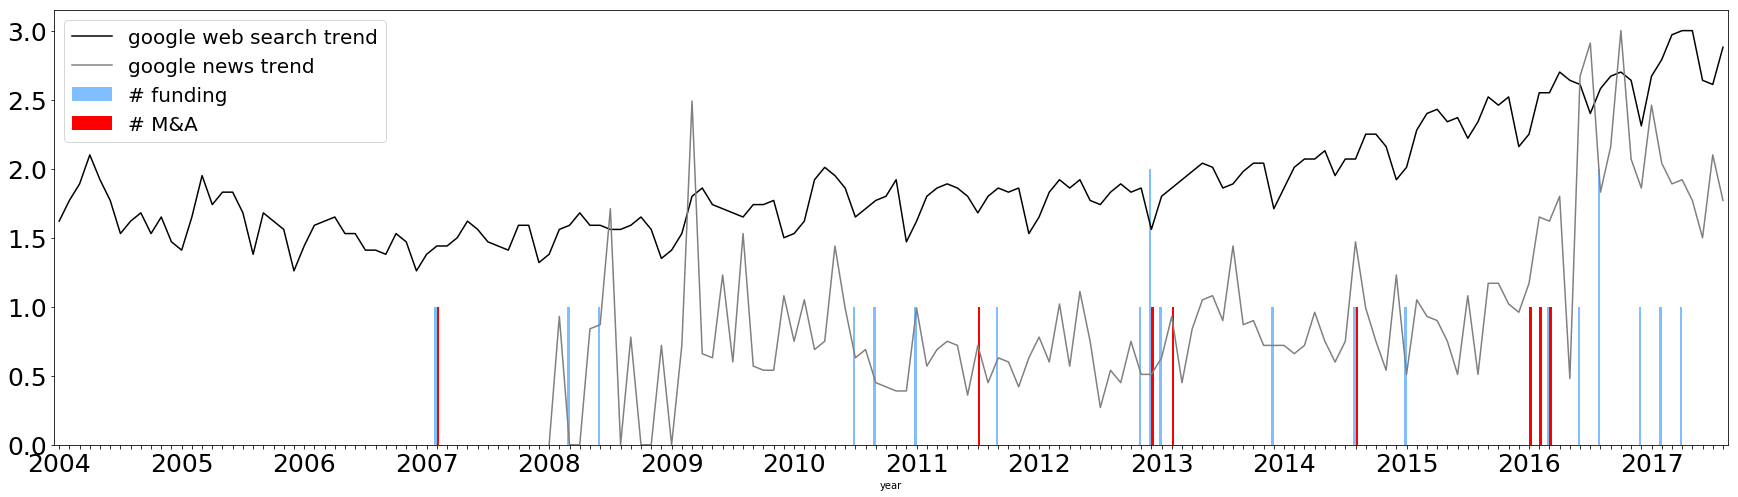

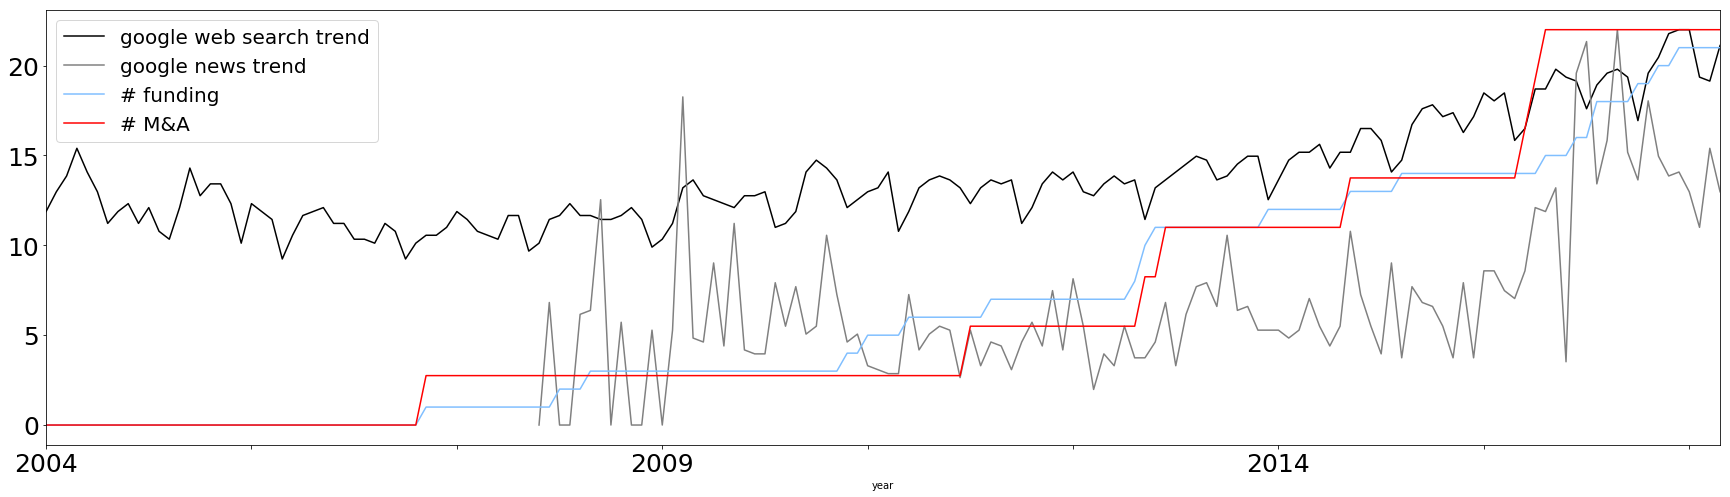

In [83]:
visualize_all('lidar', 'lidar', expand = False, plot_all = False)

Google Trend: chatbot
 Companies with keywords:['chat_bot', 'chatbot', 'ibm_watson', 'siri']
acquired_on    acquiree_name
2010-04-28             Siri
2014-03-10      Giant Media
2014-08-06    Emu Messenger
2015-01-05           Wit.ai
2015-05-29         Tempo AI
2016-02-23        BlueKloud
2016-10-18        Chatimity
2017-06-30  Chatbot Incubat


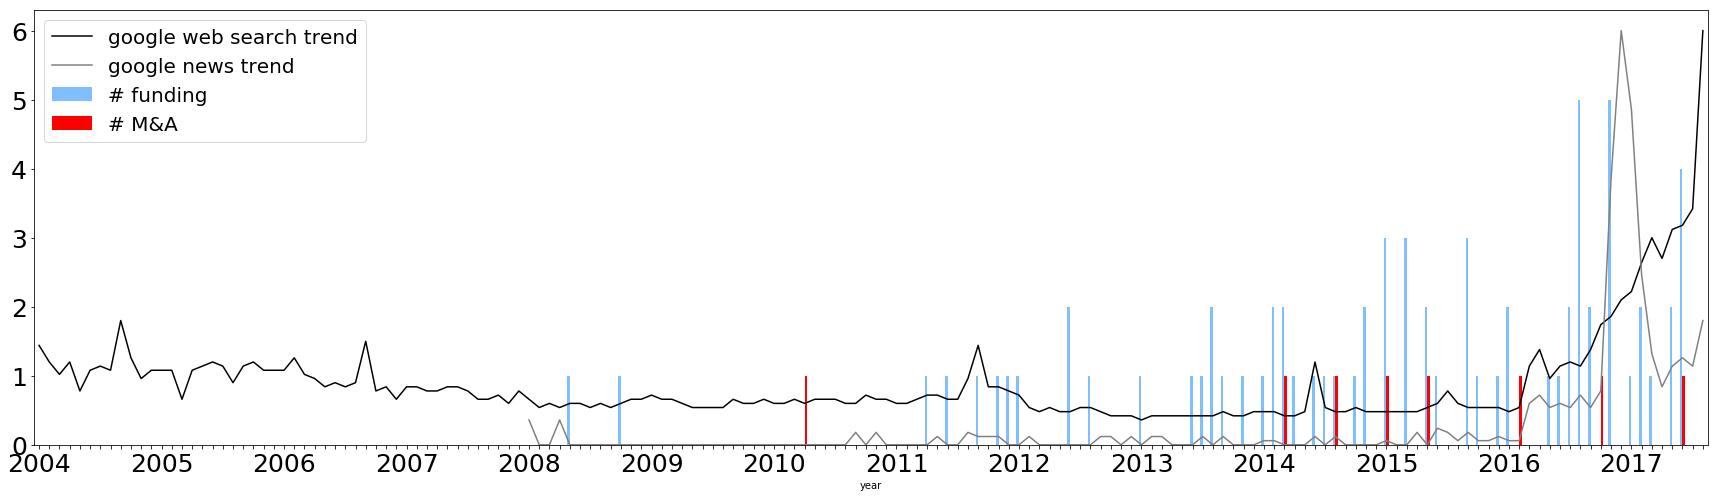

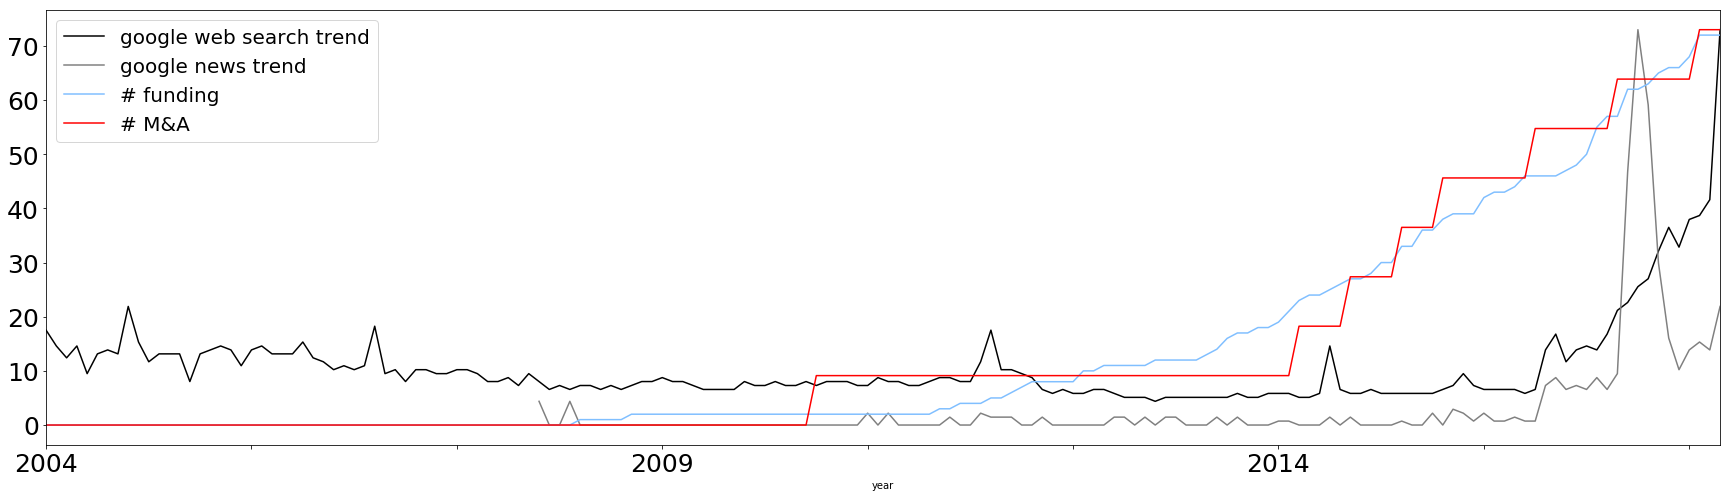

In [84]:
# visualize_all('chatbot', ['chatbot', 'conversational', 'chat bot', 'ibm watson', 'siri'], expand = False, plot_all = False)
visualize_all('chatbot', ['chatbot', 'chat bot', 'ibm watson', 'siri'], expand = False, plot_all = False)

Google Trend: fintech
 Companies with keywords:['fintech']
acquired_on    acquiree_name
2012-01-13       ORCA, Inc.
2015-03-25       Clientific
2015-10-27           Kusiri
2016-05-28     Target Group
2016-07-11            Sling
2016-10-03             Byng
2016-10-20  GMEX Technologi
2016-12-19   Working Status
2017-01-18         SparkFin
2017-05-10       Matchi.biz
2017-06-19          Perseus


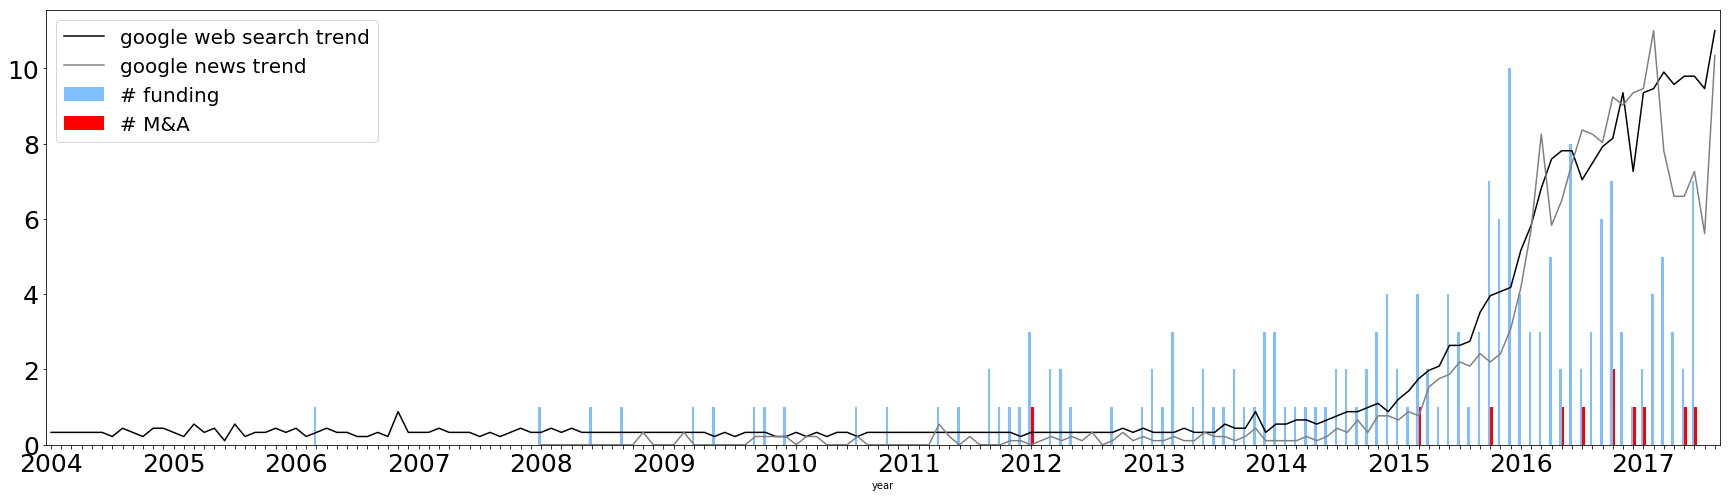

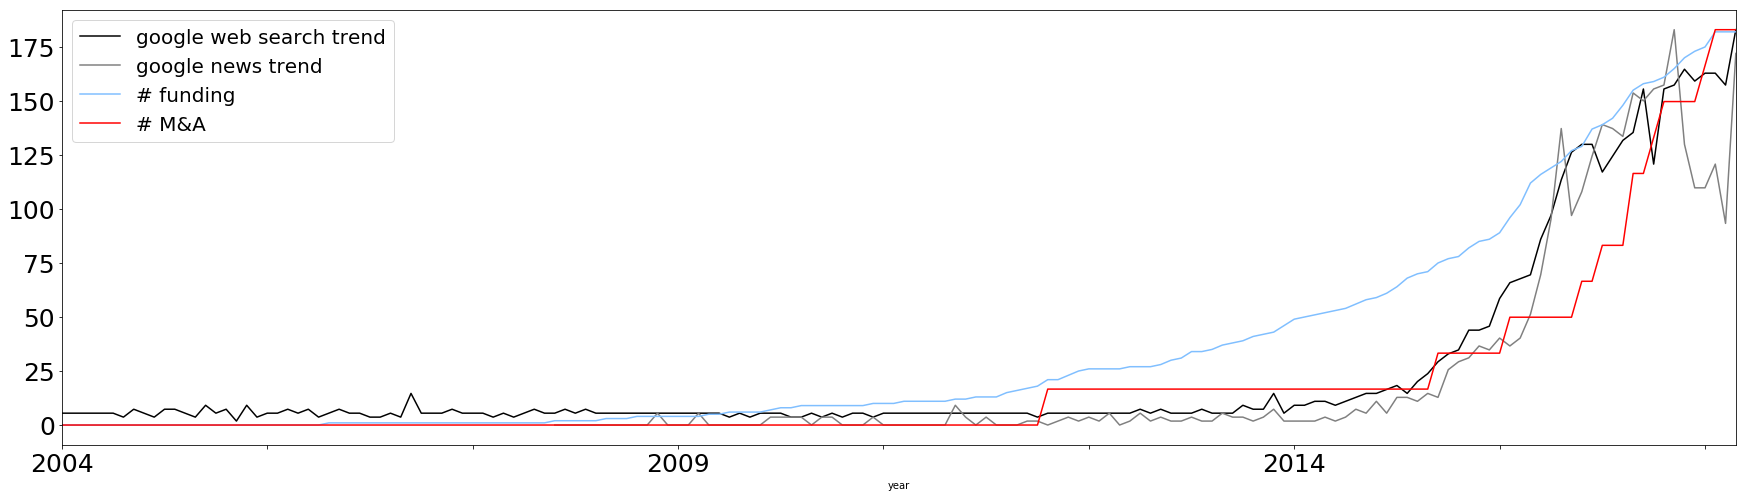

In [85]:
visualize_all('fintech', 'fintech', expand = False, plot_all = False)

Google Trend: 3d_printing
 Companies with keywords:[]
Empty DataFrame
Columns: [acquired_on, acquiree_name]
Index: []


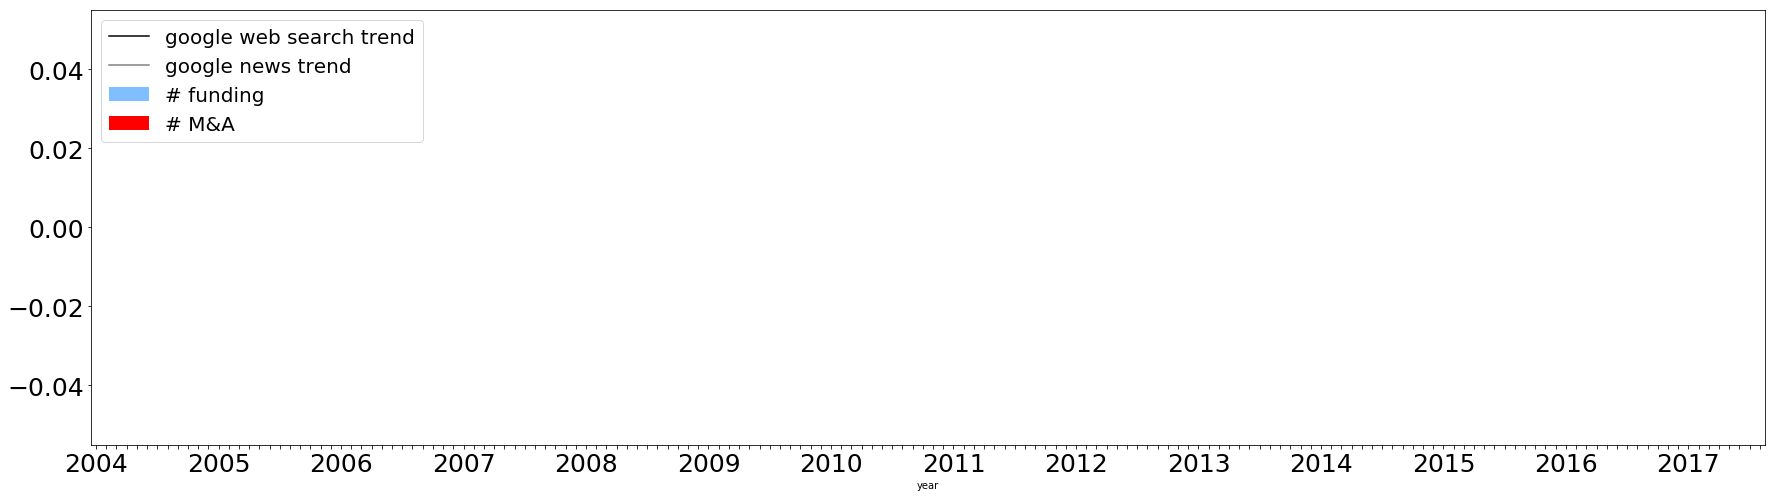

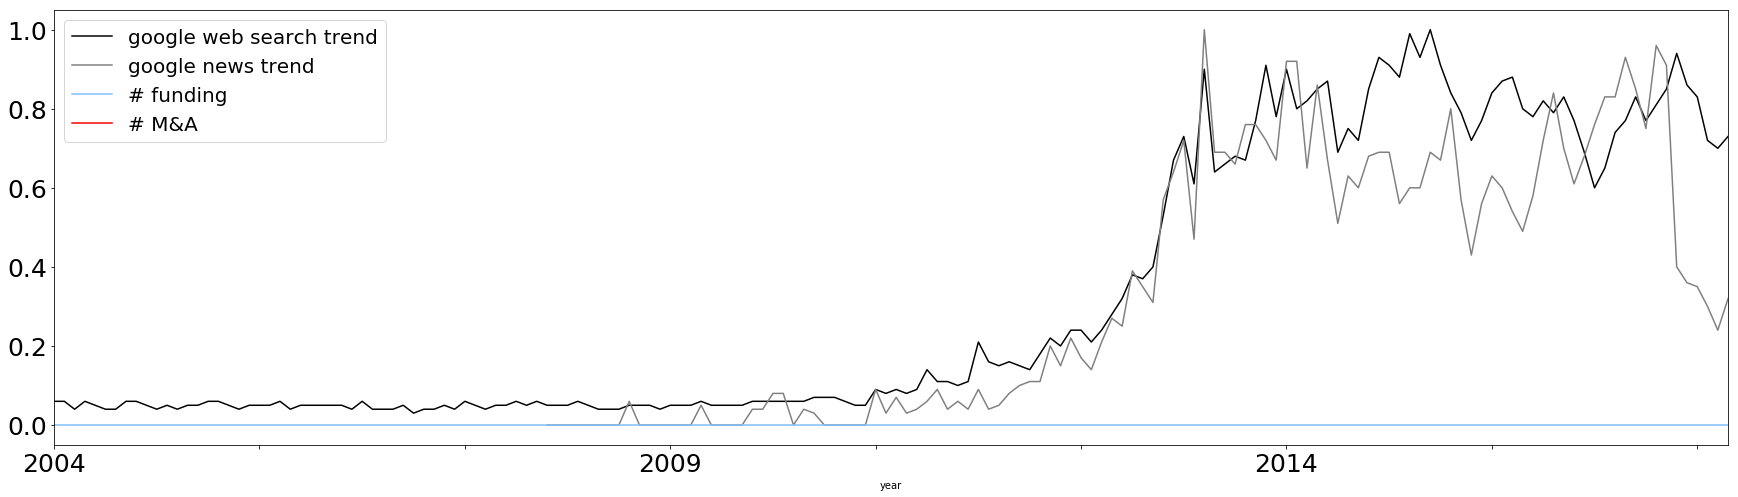

In [86]:
visualize_all('3d_printing', '3d printing', expand = True, plot_all = False)

Google Trend: quantum_computing
 Companies with keywords:['quantum_computing']
Empty DataFrame
Columns: [acquired_on, acquiree_name]
Index: []


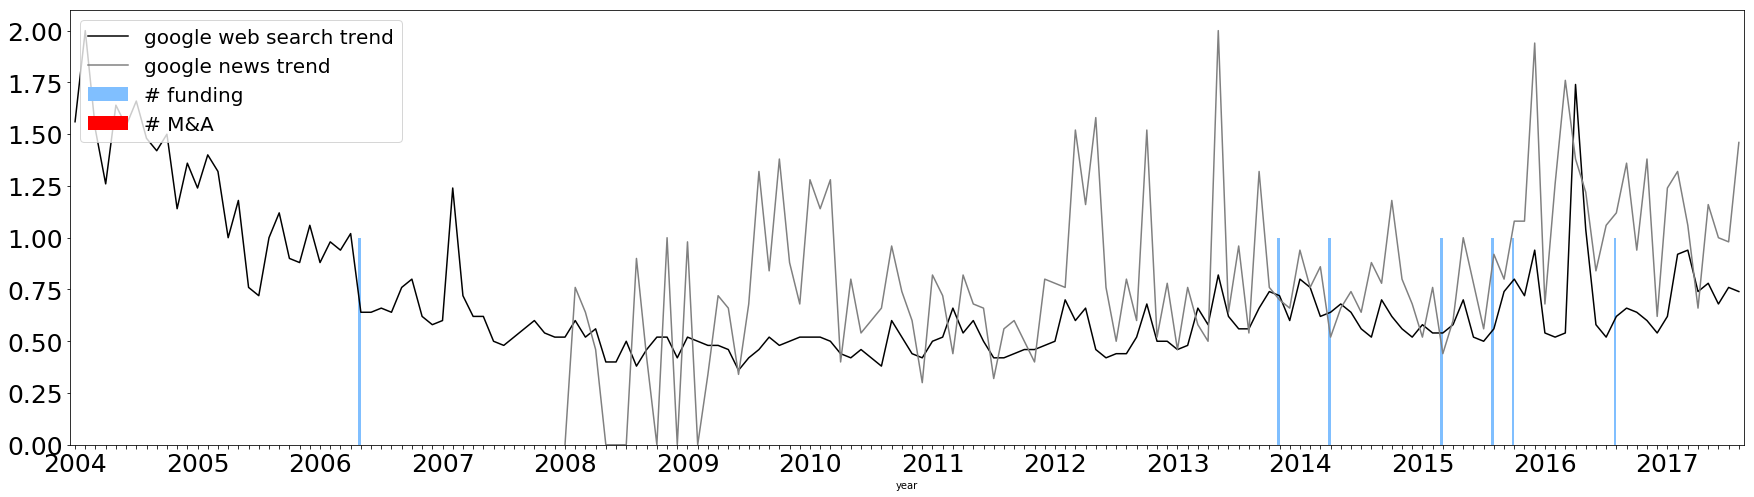

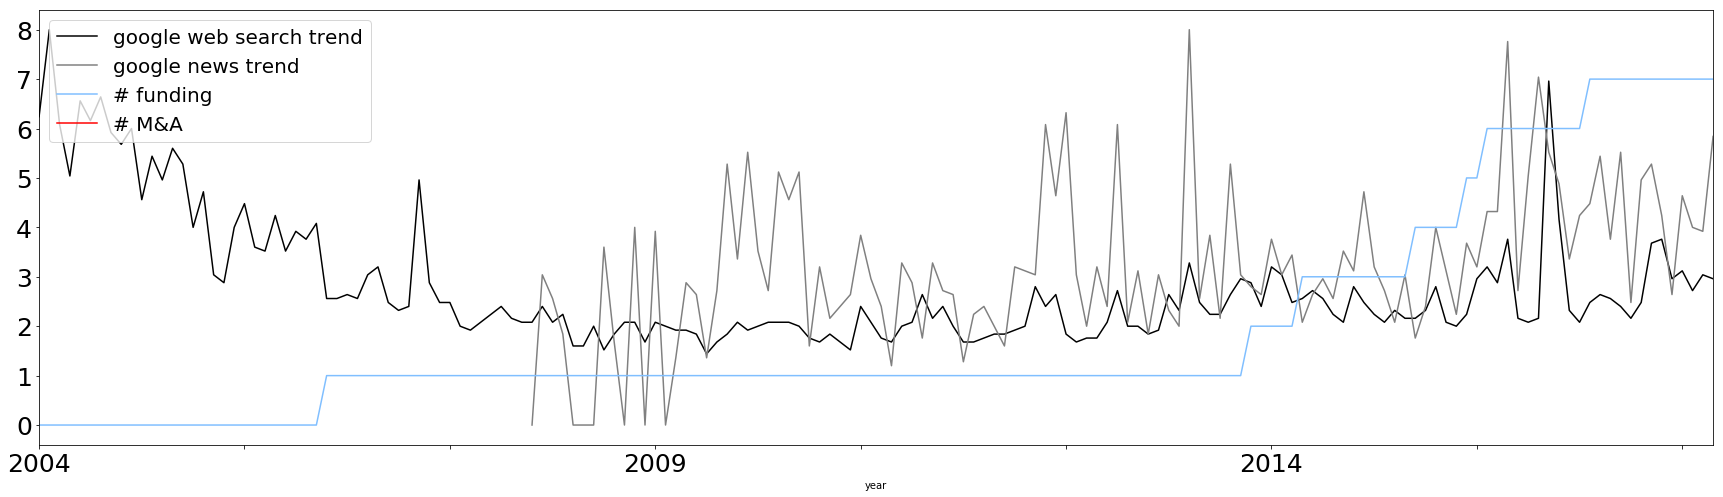

In [87]:
visualize_all('quantum_computing', 'quantum_computing', expand = False, plot_all = False)